<a href="https://colab.research.google.com/github/Lucio-MR/Elasticidades/blob/main/Elasticidades_Chido.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Importamos la paqueteria a usar
import pandas as pd
import numpy as np
from IPython.display import display
import datetime as dt
from google.colab import drive
import re

import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

#import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import Ridge
import pickle
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.ensemble import ExtraTreesRegressor

import warnings
warnings.simplefilter('ignore')

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
#Leemos los datos
#data = pd.read_excel('/content/drive/MyDrive/Elasticidades/Data/dataset_FINAL_elasticidades_nido_kinder.xlsx')
data = pd.read_csv('/content/drive/MyDrive/Elasticidades/Data/CREMADORES.csv')
#data = pd.read_excel('/content/drive/MyDrive/Elasticidades/Data/Dataset_lacteos_culinarios.xlsx', sheet_name = 'all_modelado')

In [6]:
#Primeros registros
display(data.head())

MERCADO  ... Modelar
0  TOTAL AUTOS SCANNING MEXICO  ...       1
1  TOTAL AUTOS SCANNING MEXICO  ...       1
2  TOTAL AUTOS SCANNING MEXICO  ...       1
3  TOTAL AUTOS SCANNING MEXICO  ...       1
4  TOTAL AUTOS SCANNING MEXICO  ...       1

[5 rows x 25 columns]

In [7]:
#Quitamos los espacios a los nombres de las columnas
data.columns = [x.strip() for x in data.columns]

#Renombramos
data.rename(columns = {
                       'FE_new':'Marca',
                       'name_2':'Marca',
                       'unidades':'VentasUnidades',
                       'valor':'VentasValor',
                       'eq':'VentasUnidadesEQ',
                       'kilos':'VentasKilos',
                       'date':'date_key',
                       'modelar':'Modelar'
                       }, inplace = True)

In [8]:
#Filtramos lo que vamos a modelar
data = data[data['Modelar'] == 1]

In [9]:
#Dimensiones de la base
print("Numero de filas: ", str(data.shape[0]), "\nNumero de columnas: ", str(data.shape[1]) + "\n")

Numero de filas:  6044 
Numero de columnas:  25



In [10]:
#Tipos de datos
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6044 entries, 0 to 6043
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   MERCADO                6044 non-null   object 
 1   PROD_TAG               6044 non-null   object 
 2   DESCRIPCION            6044 non-null   object 
 3   CATEGORIA              6044 non-null   object 
 4   FABRICANTE             6044 non-null   object 
 5   MARCA                  6044 non-null   object 
 6   SABOR                  5912 non-null   object 
 7   PRESENTACION           6044 non-null   object 
 8   ENVASE                 5912 non-null   object 
 9   PesoConvertido         5912 non-null   float64
 10  ITEM                   6044 non-null   int64  
 11  SEM                    6044 non-null   object 
 12  MES                    6044 non-null   object 
 13  ANIO                   6044 non-null   int64  
 14  VentasUnidades         6044 non-null   int64  
 15  Vent

In [11]:
#Quitamos las columnas que no ocupamos
data.drop(['xx','x1','Flag','_','name_3'], axis = 1, inplace = True, errors = 'ignore')
print("Numero de filas: ", str(data.shape[0]), "\nNumero de columnas: ", str(data.shape[1]) + "\n")

Numero de filas:  6044 
Numero de columnas:  24



In [12]:
#Buscamos el numero de faltantes (ya no hay faltantes)
display(pd.DataFrame(data.isnull().sum()))
#data.isna().sum().plot(kind = 'bar')

0
MERCADO                  0
PROD_TAG                 0
DESCRIPCION              0
CATEGORIA                0
FABRICANTE               0
MARCA                    0
SABOR                  132
PRESENTACION             0
ENVASE                 132
PesoConvertido         132
ITEM                     0
SEM                      0
MES                      0
ANIO                     0
VentasUnidades           0
VentasValor              0
VentasUnidadesEQ         0
DistribucionNumerica     0
DistribucionPonderada    0
PrecioPromedio           0
MESNUM                   0
Name 2                   0
Marca                    0
Modelar                  0

In [13]:
#Valores unicos por columna
display(pd.DataFrame(data.nunique()))

0
MERCADO                   1
PROD_TAG                 98
DESCRIPCION              98
CATEGORIA                 1
FABRICANTE                5
MARCA                     5
SABOR                    20
PRESENTACION              2
ENVASE                    7
PesoConvertido           33
ITEM                     96
SEM                     144
MES                      12
ANIO                      3
VentasUnidades         4070
VentasValor            5330
VentasUnidadesEQ       3561
DistribucionNumerica     99
DistribucionPonderada   101
PrecioPromedio         4988
MESNUM                   12
Name 2                   28
Marca                    48
Modelar                   1

In [14]:
#Duplicados todas las columnas
data.duplicated().sum()

0

In [15]:
#Creamos una llave para el periodo en caso de que no venga fecha
if 'date_key' not in data.columns:
  data['MESNUM2'] = ['0'+str(x) if x < 10 else str(x) for x in data['MESNUM']]
  data['date_key'] = data['ANIO'].astype(str) + '-' + data['MESNUM2'].astype(str) + '-' + data['SEM'].astype(str)
  data.drop(['MESNUM2'], axis = 1, inplace = True)

In [16]:
data.columns

Index(['MERCADO', 'PROD_TAG', 'DESCRIPCION', 'CATEGORIA', 'FABRICANTE',
       'MARCA', 'SABOR', 'PRESENTACION', 'ENVASE', 'PesoConvertido', 'ITEM',
       'SEM', 'MES', 'ANIO', 'VentasUnidades', 'VentasValor',
       'VentasUnidadesEQ', 'DistribucionNumerica', 'DistribucionPonderada',
       'PrecioPromedio', 'MESNUM', 'Name 2', 'Marca', 'Modelar', 'date_key'],
      dtype='object')

In [17]:
#Duplicados ciertas columnas
data[['PROD_TAG', 'DESCRIPCION','FABRICANTE','MARCA','Marca','ANIO','MES','SEM','date_key']].duplicated().sum()

0

In [18]:
#Revisamos las ventas unidad, valor, unidades equivalentes por mes y año
dict_nombres_mes = dict(data[['MESNUM','MES']].drop_duplicates().to_dict(orient='split')['data'])
pd.options.display.float_format = '{:,}'.format
for ventas in ['VentasUnidades','VentasValor','VentasUnidadesEQ']:
    pt = pd.pivot_table(data, values = ventas, index = ['MESNUM'], columns = ['ANIO'], aggfunc = np.sum)
    pt.rename(index = dict_nombres_mes, inplace = True)
    print(ventas.upper())
    display(pd.DataFrame(pt))
    print('\n')

VENTASUNIDADES


ANIO              2019        2020        2021
MESNUM                                        
ENERO      2,046,550.0 2,485,998.0 2,640,900.0
FEBRERO    1,700,295.0 2,362,919.0 2,514,225.0
MARZO      1,845,000.0 3,235,961.0 3,079,542.0
ABRIL      1,485,703.0 2,309,411.0 2,113,331.0
MAYO       1,448,429.0 2,243,034.0 2,101,046.0
JUNIO      2,034,629.0 2,656,713.0 2,718,270.0
JULIO      1,815,106.0 2,146,020.0 2,137,133.0
AGOSTO     1,754,239.0 2,134,120.0 2,075,449.0
SEPTIEMBRE 2,424,885.0 2,600,522.0 2,703,463.0
OCTUBRE    2,313,147.0 2,208,131.0         nan
NOVIEMBRE  2,305,858.0 2,528,159.0         nan
DICIEMBRE  3,135,854.0 4,172,063.0         nan



VENTASVALOR


ANIO                2019          2020          2021
MESNUM                                              
ENERO       66,072,795.0  84,471,435.0  98,276,872.0
FEBRERO     53,959,216.0  81,671,037.0  94,098,579.0
MARZO       57,573,737.0 113,065,613.0 117,741,435.0
ABRIL       46,220,118.0  79,170,612.0  78,921,762.0
MAYO        46,005,986.0  76,828,417.0  79,151,024.0
JUNIO       65,563,964.0  89,429,714.0 100,866,901.0
JULIO       57,625,408.0  70,574,997.0  78,222,183.0
AGOSTO      56,873,775.0  72,604,223.0  78,860,160.0
SEPTIEMBRE  75,860,131.0  91,471,218.0 105,359,509.0
OCTUBRE     69,656,810.0  79,425,015.0           nan
NOVIEMBRE   74,002,963.0  92,519,728.0           nan
DICIEMBRE  107,735,377.0 155,298,270.0           nan



VENTASUNIDADESEQ


ANIO              2019        2020        2021
MESNUM                                        
ENERO        791,876.0 1,037,367.0 1,167,565.0
FEBRERO      669,801.0 1,007,396.0 1,111,024.0
MARZO        735,003.0 1,413,200.0 1,401,350.0
ABRIL        595,358.0   998,439.0   956,008.0
MAYO         590,731.0   943,738.0   957,210.0
JUNIO        827,324.0 1,129,691.0 1,226,721.0
JULIO        727,476.0   909,069.0   969,337.0
AGOSTO       726,514.0   894,872.0   942,487.0
SEPTIEMBRE   959,036.0 1,102,244.0 1,220,521.0
OCTUBRE      877,860.0   946,027.0         nan
NOVIEMBRE    923,509.0 1,103,432.0         nan
DICIEMBRE  1,313,871.0 1,864,957.0         nan

VENTASUNIDADES


ANIO                                2019      2020      2021
FABRICANTE                                                  
NESTLE                          21052388  26671132  18978894
CONTROLLED LABEL                 1810198   2657118   1984999
LAUTREC                           976587   1177207    723667
CALKINS BURKE AND ZANN.DE MEX.    272398    359710    216334
BORDEN                            198124    217884    179465

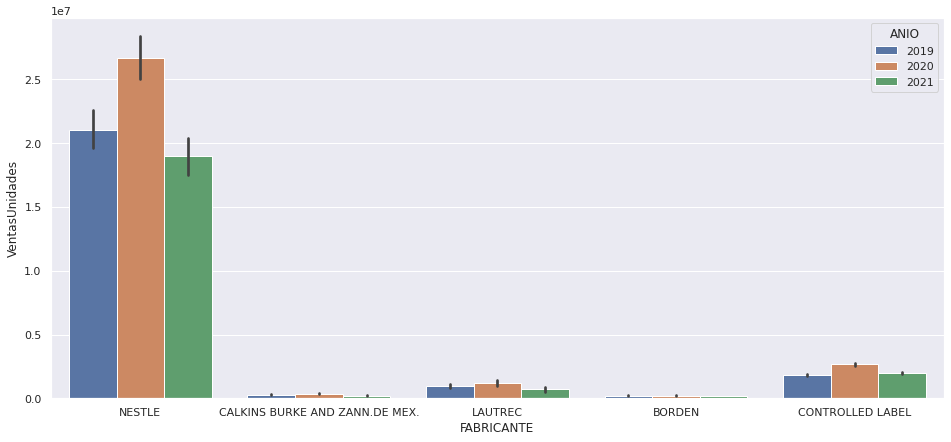



VENTASVALOR


ANIO                                 2019       2020       2021
FABRICANTE                                                     
NESTLE                          660587630  922076119  707192644
CONTROLLED LABEL                 62410378   97149360   76493630
LAUTREC                          27732921   29905272   19244287
CALKINS BURKE AND ZANN.DE MEX.   15113889   22746154   15328852
BORDEN                           11305462   14653374   13239012

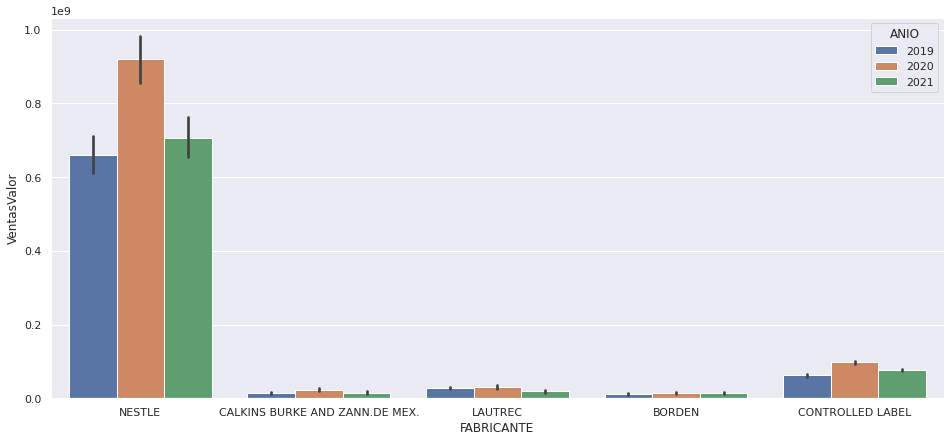



VENTASUNIDADESEQ


ANIO                               2019      2020     2021
FABRICANTE                                                
NESTLE                          8215882  11312953  8547242
CONTROLLED LABEL                 792876   1151406   833591
LAUTREC                          398786    420278   245598
CALKINS BURKE AND ZANN.DE MEX.   211935    305869   183182
BORDEN                           118880    159926   142610

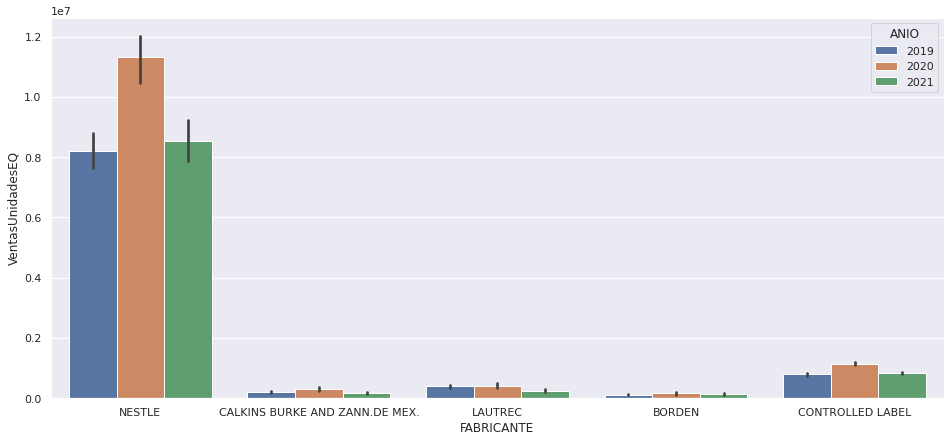

In [19]:
#Revisamos las ventas unidad, valor, unidades equivalentes por fabricante y año
pd.options.display.float_format = '{:,}'.format
for ventas in ['VentasUnidades','VentasValor','VentasUnidadesEQ']:
    pt = pd.DataFrame(pd.pivot_table(data, values = ventas, index = ['FABRICANTE'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    print(ventas.upper())
    display(pt)
    fig, ax = plt.subplots(figsize=(16,7))
    sns.barplot(data = data, x = 'FABRICANTE', y=ventas, hue='ANIO', estimator = np.sum, ax = ax)
    plt.show()
    print('\n')

2019


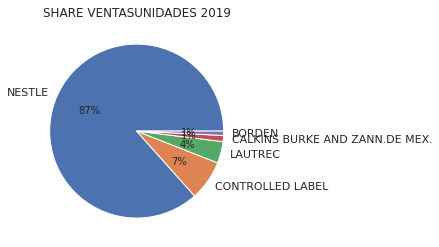

2020


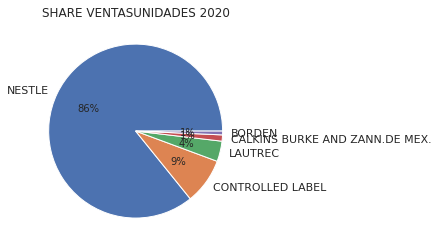

2021


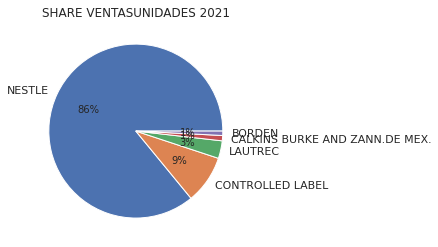

VENTASUNIDADES


ANIO                             2019   2020   2021
FABRICANTE                                         
NESTLE                         %86.60 %85.81 %85.94
CONTROLLED LABEL                %7.45  %8.55  %8.99
LAUTREC                         %4.02  %3.79  %3.28
CALKINS BURKE AND ZANN.DE MEX.  %1.12  %1.16  %0.98
BORDEN                          %0.81  %0.70  %0.81



2019


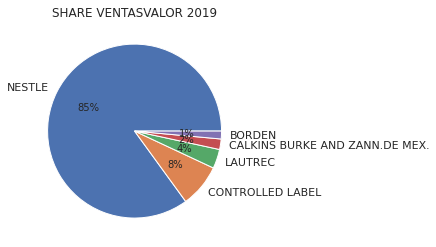

2020


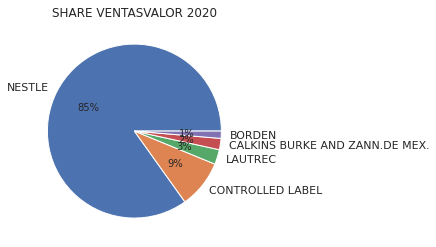

2021


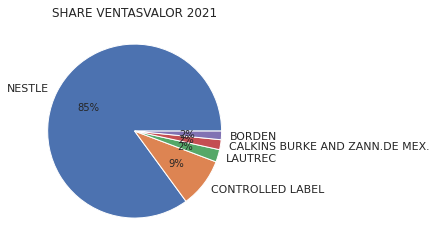

VENTASVALOR


ANIO                             2019   2020   2021
FABRICANTE                                         
NESTLE                         %85.00 %84.86 %85.05
CONTROLLED LABEL                %8.03  %8.94  %9.20
LAUTREC                         %3.57  %2.75  %2.31
CALKINS BURKE AND ZANN.DE MEX.  %1.94  %2.09  %1.84
BORDEN                          %1.45  %1.35  %1.59



2019


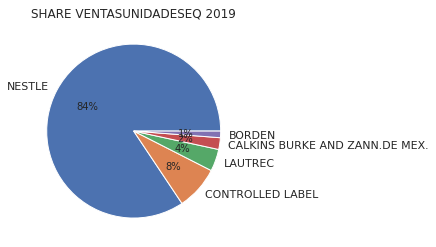

2020


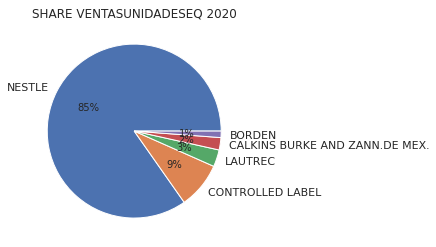

2021


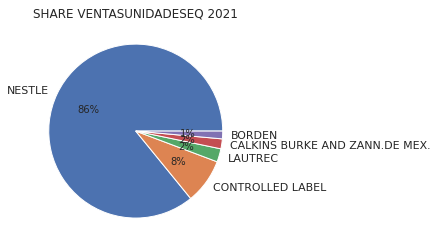

VENTASUNIDADESEQ


ANIO                             2019   2020   2021
FABRICANTE                                         
NESTLE                         %84.37 %84.74 %85.88
CONTROLLED LABEL                %8.14  %8.62  %8.38
LAUTREC                         %4.10  %3.15  %2.47
CALKINS BURKE AND ZANN.DE MEX.  %2.18  %2.29  %1.84
BORDEN                          %1.22  %1.20  %1.43

In [20]:
#Revisamos el share anual de las ventas unidad, valor, unidades equivalentes por marca y año
pd.options.display.float_format = '%{:.2f}'.format
for ventas in ['VentasUnidades','VentasValor','VentasUnidadesEQ']:
    pt = pd.DataFrame(pd.pivot_table(data, values = ventas, index = ['FABRICANTE'], columns = ['ANIO'], aggfunc = np.sum, fill_value = 0)).sort_values(2021, ascending = False, na_position = 'last')
    pt_sum = pt.sum()
    for col in np.sort(data['ANIO'].unique()):
        print(col)
        pt[col] = (pt[col] / pt_sum[col]) * 100
        plt.pie(pt[col], labels = pt.index, autopct='%.0f%%')
        plt.title("SHARE " + ventas.upper() + ' ' + str(col))
        plt.show()
    print(ventas.upper())
    display(pd.DataFrame(pt))
    print('\n')

In [21]:
#Revisamos el precio promedio anual y el precio promedio eq por FE
pd.options.display.float_format = '${:.2f}'.format
for ventas in ['VentasUnidades','VentasUnidadesEQ']:
    pt_unid = pd.DataFrame(pd.pivot_table(data, values = ventas, index = ['FABRICANTE'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    pt_valor = pd.DataFrame(pd.pivot_table(data, values = 'VentasValor', index = ['FABRICANTE'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    pt_valor = pt_valor.div(pt_unid, axis = 1, fill_value=0)
    #for col in [2018,2019,2020,2021]:
    #    pt[col] = (pt[col] / pt_sum[col]) * 100
    print(ventas.upper())
    display(pd.DataFrame(pt_valor))
    print('\n')

VENTASUNIDADES


ANIO                             2019   2020   2021
FABRICANTE                                         
NESTLE                         $31.38 $34.57 $37.26
CONTROLLED LABEL               $34.48 $36.56 $38.54
LAUTREC                        $28.40 $25.40 $26.59
CALKINS BURKE AND ZANN.DE MEX. $55.48 $63.23 $70.86
BORDEN                         $57.06 $67.25 $73.77



VENTASUNIDADESEQ


ANIO                             2019   2020   2021
FABRICANTE                                         
NESTLE                         $80.40 $81.51 $82.74
CONTROLLED LABEL               $78.71 $84.37 $91.76
LAUTREC                        $69.54 $71.16 $78.36
CALKINS BURKE AND ZANN.DE MEX. $71.31 $74.37 $83.68
BORDEN                         $95.10 $91.63 $92.83

In [22]:
#Revisamos las ventas unidad, valor, unidades equivalentes por FE_new
pd.options.display.float_format = '{:,}'.format
for ventas in ['VentasUnidades','VentasValor','VentasUnidadesEQ']:
    pt = pd.pivot_table(data, values = ventas, index = ['Marca'], columns = ['ANIO'], aggfunc = np.sum).sort_values(2021, ascending = False, na_position = 'last')
    print(ventas.upper())
    display(pd.DataFrame(pt))
    print('\n')

VENTASUNIDADES


ANIO                                       2019         2020        2021
Marca                                                                   
COFFEE MATE_LIQUIDO_CARTON_530      4,679,354.0 10,580,977.0 8,357,970.0
COFFEE MATE_POLVO_BOTE_400          3,757,635.0  4,578,820.0 3,150,361.0
COFFEE MATE_POLVO_BOLSA_210         2,204,820.0  2,753,563.0 2,047,623.0
COFFEE MATE_POLVO_BOTE_160          3,042,896.0  3,071,193.0 1,990,052.0
CONTROLLED LABEL_CONTROLLED LABEL__ 1,810,198.0  2,657,118.0 1,984,999.0
COFFEE MATE_LIQUIDO_BOTE_530          568,622.0  1,404,724.0 1,158,306.0
COFFEE MATE_POLVO_BOTE_640            625,875.0  1,302,820.0   800,862.0
LAUTREC_POLVO_BOLSA_300               738,953.0    999,492.0   663,210.0
COFFEE MATE_POLVO_LATA_900                  nan    390,089.0   628,299.0
COFFEE MATE_POLVO_BOLSA_260           546,164.0    532,874.0   440,427.0
COFFEE MATE_POLVO_LATA_1200                 nan          nan   186,101.0
CORINA_POLVO_BOTE_1000                168,407.0    252,367.0   147,879.0
COFFEE MATE_POLVO_BOTE_311          1,202,738.0    566,640.0   147,576.0
CREMORA_POLVO_BOTE_1000               102,645.0    148,060.0   135,065.0
CREMORA_POLVO_BOTE_170                 95,479.0     69,824.0    44,400.0
CORINA_POLVO_DOY PACK_227              73,172.0     63,859.0    40,572.0
LAUTREC_POLVO_LATA_1000               146,354.0     91,473.0    39,467.0
COFFEE MATE_POLVO_SOBRE_34            811,692.0    932,972.0    38,739.0
COFFEE MATE_POLVO_BOLSA_1000                nan        171.0    30,277.0
CORINA_POLVO_BOLSA_1000                23,679.0     35,291.0    24,607.0
LAUTREC_POLVO_BOTE_460                 48,052.0     45,025.0    11,429.0
LAUTREC_POLVO_BOTE_200                 43,228.0     41,217.0     9,561.0
CORINA_POLVO_BOTE_454                   7,140.0      8,193.0     3,276.0
COFFEE MATE_POLVO_SOBRE_4               2,404.0      1,260.0     1,775.0
COFFEE MATE_LIQUIDO_BOTE_500        3,068,108.0        689.0       251.0
COFFEE MATE_POLVO_DOY PACK_253             13.0        278.0       174.0
COFFEE MATE_POLVO_BOLSA_950           515,054.0    400,710.0        71.0
COFFEE MATE_LIQUIDO_BOTE_750               16.0          9.0        13.0
COFFEE MATE_POLVO_BOTE_210                 11.0          5.0         6.0
COFFEE MATE_LIQUIDO_BOTE_330            9,906.0          2.0         3.0
COFFEE MATE_POLVO_BOTE_930                  7.0        523.0         3.0
COFFEE MATE_POLVO_DOY PACK_227              8.0          2.0         2.0
COFFEE MATE_POLVO_SOBRE_250                 2.0          1.0         1.0
COFFEE MATE_POLVO_BOTE_453                  2.0          1.0         1.0
COFFEE MATE_POLVO_BOLSA_250                 2.0          nan         1.0
COFFEE MATE_LIQUIDO_BOTE_473                5.0          3.0         nan
COFFEE MATE_LIQUIDO_CARTON_500         16,945.0          nan         nan
COFFEE MATE_POLVO_BOTE_170                 14.0          4.0         nan
COFFEE MATE_POLVO_BOTE_226                  3.0          nan         nan
COFFEE MATE_POLVO_BOTE_420                 51.0          7.0         nan
COFFEE MATE_POLVO_BOTE_520                  3.0         11.0         nan
COFFEE MATE_POLVO_BOTE_950                  nan    152,760.0         nan
COFFEE MATE_POLVO_DOY PACK_220             24.0         14.0         nan
COFFEE MATE_POLVO_DOY PACK_226              1.0          nan         nan
COFFEE MATE_POLVO_FRASCO_1000               nan          1.0         nan
COFFEE MATE_POLVO_LATA_400                  5.0          nan         nan
COFFEE MATE_POLVO_SOBRE_36                  3.0          2.0         nan
COFFEE MATE_POLVO_SOBRE_40                  5.0          7.0         nan



VENTASVALOR


ANIO                                         2019          2020          2021
Marca                                                                        
COFFEE MATE_LIQUIDO_CARTON_530      115,709,389.0 274,667,699.0 230,319,990.0
COFFEE MATE_POLVO_BOTE_400          158,647,654.0 219,220,811.0 159,046,580.0
CONTROLLED LABEL_CONTROLLED LABEL__  62,410,378.0  97,149,360.0  76,493,630.0
COFFEE MATE_POLVO_LATA_900                    nan  38,949,661.0  64,051,268.0
COFFEE MATE_POLVO_BOTE_640           43,626,323.0  94,634,295.0  61,952,078.0
COFFEE MATE_POLVO_BOLSA_210          63,611,502.0  82,924,091.0  55,346,786.0
COFFEE MATE_POLVO_BOTE_160           72,005,402.0  77,615,561.0  55,311,165.0
COFFEE MATE_LIQUIDO_BOTE_530         14,059,153.0  36,606,707.0  32,125,077.0
COFFEE MATE_POLVO_LATA_1200                   nan           nan  24,649,891.0
LAUTREC_POLVO_BOLSA_300              15,607,408.0  20,688,249.0  15,327,879.0
COFFEE MATE_POLVO_BOLSA_260          15,118,093.0  15,524,218.0  14,299,248.0
CREMORA_POLVO_BOTE_1000               9,122,991.0  12,936,429.0  12,132,066.0
CORINA_POLVO_BOTE_1000               11,602,428.0  18,182,197.0  12,108,236.0
COFFEE MATE_POLVO_BOTE_311           46,168,979.0  23,415,866.0   6,548,790.0
LAUTREC_POLVO_LATA_1000               9,187,803.0   6,524,671.0   3,139,841.0
COFFEE MATE_POLVO_BOLSA_1000                  nan      18,556.0   3,072,681.0
CORINA_POLVO_BOLSA_1000               1,450,974.0   2,618,133.0   1,958,442.0
CREMORA_POLVO_BOTE_170                2,182,471.0   1,716,945.0   1,106,946.0
CORINA_POLVO_DOY PACK_227             1,707,332.0   1,552,026.0   1,106,151.0
LAUTREC_POLVO_BOTE_460                2,057,859.0   1,846,153.0     542,370.0
COFFEE MATE_POLVO_SOBRE_34            4,648,790.0   5,497,685.0     236,234.0
LAUTREC_POLVO_BOTE_200                  879,851.0     846,199.0     234,197.0
COFFEE MATE_POLVO_SOBRE_4               255,826.0     139,094.0     213,366.0
CORINA_POLVO_BOTE_454                   353,155.0     393,798.0     156,023.0
COFFEE MATE_POLVO_BOLSA_950          49,886,519.0  40,249,995.0       7,268.0
COFFEE MATE_POLVO_DOY PACK_253              269.0       8,829.0       5,720.0
COFFEE MATE_LIQUIDO_BOTE_500         76,344,789.0      12,079.0       5,693.0
COFFEE MATE_POLVO_BOTE_930                  679.0      51,145.0         294.0
COFFEE MATE_LIQUIDO_BOTE_750                307.0         177.0         246.0
COFFEE MATE_POLVO_BOTE_210                  282.0         100.0          76.0
COFFEE MATE_LIQUIDO_BOTE_330            122,236.0          40.0          60.0
COFFEE MATE_POLVO_DOY PACK_227              215.0          51.0          55.0
COFFEE MATE_POLVO_BOTE_453                   73.0          45.0          36.0
COFFEE MATE_POLVO_SOBRE_250                  42.0          21.0          21.0
COFFEE MATE_POLVO_BOLSA_250                  43.0           nan          21.0
COFFEE MATE_LIQUIDO_BOTE_473                165.0          85.0           nan
COFFEE MATE_LIQUIDO_CARTON_500          377,679.0           nan           nan
COFFEE MATE_POLVO_BOTE_170                  259.0          93.0           nan
COFFEE MATE_POLVO_BOTE_226                   60.0           nan           nan
COFFEE MATE_POLVO_BOTE_420                2,055.0         208.0           nan
COFFEE MATE_POLVO_BOTE_520                  116.0         449.0           nan
COFFEE MATE_POLVO_BOTE_950                    nan  12,538,107.0           nan
COFFEE MATE_POLVO_DOY PACK_220              504.0         320.0           nan
COFFEE MATE_POLVO_DOY PACK_226               29.0           nan           nan
COFFEE MATE_POLVO_FRASCO_1000                 nan          76.0           nan
COFFEE MATE_POLVO_LATA_400                  150.0           nan           nan
COFFEE MATE_POLVO_SOBRE_36                   18.0          13.0           nan
COFFEE MATE_POLVO_SOBRE_40                   30.0          42.0           nan



VENTASUNIDADESEQ


ANIO                                       2019        2020        2021
Marca                                                                  
COFFEE MATE_LIQUIDO_CARTON_530      2,480,059.0 5,607,920.0 4,429,721.0
COFFEE MATE_POLVO_BOTE_400          1,503,046.0 1,831,526.0 1,260,147.0
CONTROLLED LABEL_CONTROLLED LABEL__   792,876.0 1,151,406.0   833,591.0
COFFEE MATE_LIQUIDO_BOTE_530          301,368.0   744,500.0   613,903.0
COFFEE MATE_POLVO_LATA_900                  nan   351,080.0   565,470.0
COFFEE MATE_POLVO_BOTE_640            400,563.0   833,806.0   512,554.0
COFFEE MATE_POLVO_BOLSA_210           463,011.0   578,249.0   430,000.0
COFFEE MATE_POLVO_BOTE_160            486,868.0   491,391.0   318,407.0
COFFEE MATE_POLVO_LATA_1200                 nan         nan   223,323.0
LAUTREC_POLVO_BOLSA_300               221,686.0   299,850.0   198,962.0
CORINA_POLVO_BOTE_1000                168,407.0   252,367.0   147,879.0
CREMORA_POLVO_BOTE_1000               102,645.0   148,060.0   135,065.0
COFFEE MATE_POLVO_BOLSA_260           142,003.0   138,550.0   114,510.0
COFFEE MATE_POLVO_BOTE_311            374,048.0   176,227.0    45,888.0
LAUTREC_POLVO_LATA_1000               146,354.0    91,473.0    39,467.0
COFFEE MATE_POLVO_BOLSA_1000                nan       171.0    30,277.0
CORINA_POLVO_BOLSA_1000                23,679.0    35,291.0    24,607.0
CORINA_POLVO_DOY PACK_227              16,608.0    14,493.0     9,210.0
CREMORA_POLVO_BOTE_170                 16,235.0    11,866.0     7,545.0
LAUTREC_POLVO_BOTE_460                 22,104.0    20,715.0     5,256.0
LAUTREC_POLVO_BOTE_200                  8,642.0     8,240.0     1,913.0
CORINA_POLVO_BOTE_454                   3,241.0     3,718.0     1,486.0
COFFEE MATE_POLVO_SOBRE_4               1,926.0     1,008.0     1,421.0
COFFEE MATE_POLVO_SOBRE_34             27,743.0    31,760.0     1,337.0
COFFEE MATE_LIQUIDO_BOTE_500        1,534,141.0       382.0       151.0
COFFEE MATE_POLVO_BOLSA_950           489,304.0   380,677.0        71.0
COFFEE MATE_POLVO_DOY PACK_253              3.0        77.0        47.0
COFFEE MATE_LIQUIDO_BOTE_750               15.0         9.0        12.0
COFFEE MATE_POLVO_BOTE_930                  7.0       487.0         3.0
COFFEE MATE_LIQUIDO_BOTE_330            3,270.0         0.0         0.0
COFFEE MATE_POLVO_SOBRE_250                 0.0         0.0         0.0
COFFEE MATE_POLVO_BOTE_453                  0.0         0.0         0.0
COFFEE MATE_POLVO_BOTE_210                  1.0         0.0         0.0
COFFEE MATE_POLVO_BOLSA_250                 1.0         nan         0.0
COFFEE MATE_POLVO_DOY PACK_227              0.0         0.0         0.0
COFFEE MATE_LIQUIDO_BOTE_473                1.0         0.0         nan
COFFEE MATE_LIQUIDO_CARTON_500          8,476.0         nan         nan
COFFEE MATE_POLVO_BOTE_170                  1.0         0.0         nan
COFFEE MATE_POLVO_BOTE_226                  0.0         nan         nan
COFFEE MATE_POLVO_BOTE_420                 21.0         2.0         nan
COFFEE MATE_POLVO_BOTE_520                  2.0         8.0         nan
COFFEE MATE_POLVO_BOTE_950                  nan   145,120.0         nan
COFFEE MATE_POLVO_DOY PACK_220              4.0         2.0         nan
COFFEE MATE_POLVO_DOY PACK_226              0.0         nan         nan
COFFEE MATE_POLVO_FRASCO_1000               nan         1.0         nan
COFFEE MATE_POLVO_LATA_400                  0.0         nan         nan
COFFEE MATE_POLVO_SOBRE_36                  0.0         0.0         nan
COFFEE MATE_POLVO_SOBRE_40                  0.0         0.0         nan

In [23]:
#Revisamos el share anual de las ventas unidad, valor, unidades equivalentes por FE
pd.options.display.float_format = '%{:.2f}'.format
for ventas in ['VentasUnidades','VentasValor','VentasUnidadesEQ']:
    pt = pd.DataFrame(pd.pivot_table(data, values = ventas, index = ['Marca'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    pt_sum = pt.sum()
    for col in np.sort(data['ANIO'].unique()):
        pt[col] = (pt[col] / pt_sum[col]) * 100
    print(ventas.upper())
    display(pd.DataFrame(pt))
    print('\n')

VENTASUNIDADES


ANIO                                  2019   2020   2021
Marca                                                   
COFFEE MATE_LIQUIDO_CARTON_530      %19.25 %34.04 %37.85
COFFEE MATE_POLVO_BOTE_400          %15.46 %14.73 %14.27
COFFEE MATE_POLVO_BOLSA_210          %9.07  %8.86  %9.27
COFFEE MATE_POLVO_BOTE_160          %12.52  %9.88  %9.01
CONTROLLED LABEL_CONTROLLED LABEL__  %7.45  %8.55  %8.99
COFFEE MATE_LIQUIDO_BOTE_530         %2.34  %4.52  %5.25
COFFEE MATE_POLVO_BOTE_640           %2.57  %4.19  %3.63
LAUTREC_POLVO_BOLSA_300              %3.04  %3.22  %3.00
COFFEE MATE_POLVO_LATA_900            %nan  %1.25  %2.85
COFFEE MATE_POLVO_BOLSA_260          %2.25  %1.71  %1.99
COFFEE MATE_POLVO_LATA_1200           %nan   %nan  %0.84
CORINA_POLVO_BOTE_1000               %0.69  %0.81  %0.67
COFFEE MATE_POLVO_BOTE_311           %4.95  %1.82  %0.67
CREMORA_POLVO_BOTE_1000              %0.42  %0.48  %0.61
CREMORA_POLVO_BOTE_170               %0.39  %0.22  %0.20
CORINA_POLVO_DOY PACK_227            %0.30  %0.21  %0.18
LAUTREC_POLVO_LATA_1000              %0.60  %0.29  %0.18
COFFEE MATE_POLVO_SOBRE_34           %3.34  %3.00  %0.18
COFFEE MATE_POLVO_BOLSA_1000          %nan  %0.00  %0.14
CORINA_POLVO_BOLSA_1000              %0.10  %0.11  %0.11
LAUTREC_POLVO_BOTE_460               %0.20  %0.14  %0.05
LAUTREC_POLVO_BOTE_200               %0.18  %0.13  %0.04
CORINA_POLVO_BOTE_454                %0.03  %0.03  %0.01
COFFEE MATE_POLVO_SOBRE_4            %0.01  %0.00  %0.01
COFFEE MATE_LIQUIDO_BOTE_500        %12.62  %0.00  %0.00
COFFEE MATE_POLVO_DOY PACK_253       %0.00  %0.00  %0.00
COFFEE MATE_POLVO_BOLSA_950          %2.12  %1.29  %0.00
COFFEE MATE_LIQUIDO_BOTE_750         %0.00  %0.00  %0.00
COFFEE MATE_POLVO_BOTE_210           %0.00  %0.00  %0.00
COFFEE MATE_LIQUIDO_BOTE_330         %0.04  %0.00  %0.00
COFFEE MATE_POLVO_BOTE_930           %0.00  %0.00  %0.00
COFFEE MATE_POLVO_DOY PACK_227       %0.00  %0.00  %0.00
COFFEE MATE_POLVO_SOBRE_250          %0.00  %0.00  %0.00
COFFEE MATE_POLVO_BOTE_453           %0.00  %0.00  %0.00
COFFEE MATE_POLVO_BOLSA_250          %0.00   %nan  %0.00
COFFEE MATE_LIQUIDO_BOTE_473         %0.00  %0.00   %nan
COFFEE MATE_LIQUIDO_CARTON_500       %0.07   %nan   %nan
COFFEE MATE_POLVO_BOTE_170           %0.00  %0.00   %nan
COFFEE MATE_POLVO_BOTE_226           %0.00   %nan   %nan
COFFEE MATE_POLVO_BOTE_420           %0.00  %0.00   %nan
COFFEE MATE_POLVO_BOTE_520           %0.00  %0.00   %nan
COFFEE MATE_POLVO_BOTE_950            %nan  %0.49   %nan
COFFEE MATE_POLVO_DOY PACK_220       %0.00  %0.00   %nan
COFFEE MATE_POLVO_DOY PACK_226       %0.00   %nan   %nan
COFFEE MATE_POLVO_FRASCO_1000         %nan  %0.00   %nan
COFFEE MATE_POLVO_LATA_400           %0.00   %nan   %nan
COFFEE MATE_POLVO_SOBRE_36           %0.00  %0.00   %nan
COFFEE MATE_POLVO_SOBRE_40           %0.00  %0.00   %nan



VENTASVALOR


ANIO                                  2019   2020   2021
Marca                                                   
COFFEE MATE_LIQUIDO_CARTON_530      %14.89 %25.28 %27.70
COFFEE MATE_POLVO_BOTE_400          %20.41 %20.18 %19.13
CONTROLLED LABEL_CONTROLLED LABEL__  %8.03  %8.94  %9.20
COFFEE MATE_POLVO_LATA_900            %nan  %3.58  %7.70
COFFEE MATE_POLVO_BOTE_640           %5.61  %8.71  %7.45
COFFEE MATE_POLVO_BOLSA_210          %8.19  %7.63  %6.66
COFFEE MATE_POLVO_BOTE_160           %9.27  %7.14  %6.65
COFFEE MATE_LIQUIDO_BOTE_530         %1.81  %3.37  %3.86
COFFEE MATE_POLVO_LATA_1200           %nan   %nan  %2.96
LAUTREC_POLVO_BOLSA_300              %2.01  %1.90  %1.84
COFFEE MATE_POLVO_BOLSA_260          %1.95  %1.43  %1.72
CREMORA_POLVO_BOTE_1000              %1.17  %1.19  %1.46
CORINA_POLVO_BOTE_1000               %1.49  %1.67  %1.46
COFFEE MATE_POLVO_BOTE_311           %5.94  %2.16  %0.79
LAUTREC_POLVO_LATA_1000              %1.18  %0.60  %0.38
COFFEE MATE_POLVO_BOLSA_1000          %nan  %0.00  %0.37
CORINA_POLVO_BOLSA_1000              %0.19  %0.24  %0.24
CREMORA_POLVO_BOTE_170               %0.28  %0.16  %0.13
CORINA_POLVO_DOY PACK_227            %0.22  %0.14  %0.13
LAUTREC_POLVO_BOTE_460               %0.26  %0.17  %0.07
COFFEE MATE_POLVO_SOBRE_34           %0.60  %0.51  %0.03
LAUTREC_POLVO_BOTE_200               %0.11  %0.08  %0.03
COFFEE MATE_POLVO_SOBRE_4            %0.03  %0.01  %0.03
CORINA_POLVO_BOTE_454                %0.05  %0.04  %0.02
COFFEE MATE_POLVO_BOLSA_950          %6.42  %3.70  %0.00
COFFEE MATE_POLVO_DOY PACK_253       %0.00  %0.00  %0.00
COFFEE MATE_LIQUIDO_BOTE_500         %9.82  %0.00  %0.00
COFFEE MATE_POLVO_BOTE_930           %0.00  %0.00  %0.00
COFFEE MATE_LIQUIDO_BOTE_750         %0.00  %0.00  %0.00
COFFEE MATE_POLVO_BOTE_210           %0.00  %0.00  %0.00
COFFEE MATE_LIQUIDO_BOTE_330         %0.02  %0.00  %0.00
COFFEE MATE_POLVO_DOY PACK_227       %0.00  %0.00  %0.00
COFFEE MATE_POLVO_BOTE_453           %0.00  %0.00  %0.00
COFFEE MATE_POLVO_SOBRE_250          %0.00  %0.00  %0.00
COFFEE MATE_POLVO_BOLSA_250          %0.00   %nan  %0.00
COFFEE MATE_LIQUIDO_BOTE_473         %0.00  %0.00   %nan
COFFEE MATE_LIQUIDO_CARTON_500       %0.05   %nan   %nan
COFFEE MATE_POLVO_BOTE_170           %0.00  %0.00   %nan
COFFEE MATE_POLVO_BOTE_226           %0.00   %nan   %nan
COFFEE MATE_POLVO_BOTE_420           %0.00  %0.00   %nan
COFFEE MATE_POLVO_BOTE_520           %0.00  %0.00   %nan
COFFEE MATE_POLVO_BOTE_950            %nan  %1.15   %nan
COFFEE MATE_POLVO_DOY PACK_220       %0.00  %0.00   %nan
COFFEE MATE_POLVO_DOY PACK_226       %0.00   %nan   %nan
COFFEE MATE_POLVO_FRASCO_1000         %nan  %0.00   %nan
COFFEE MATE_POLVO_LATA_400           %0.00   %nan   %nan
COFFEE MATE_POLVO_SOBRE_36           %0.00  %0.00   %nan
COFFEE MATE_POLVO_SOBRE_40           %0.00  %0.00   %nan



VENTASUNIDADESEQ


ANIO                                  2019   2020   2021
Marca                                                   
COFFEE MATE_LIQUIDO_CARTON_530      %25.47 %42.01 %44.51
COFFEE MATE_POLVO_BOTE_400          %15.43 %13.72 %12.66
CONTROLLED LABEL_CONTROLLED LABEL__  %8.14  %8.62  %8.38
COFFEE MATE_LIQUIDO_BOTE_530         %3.09  %5.58  %6.17
COFFEE MATE_POLVO_LATA_900            %nan  %2.63  %5.68
COFFEE MATE_POLVO_BOTE_640           %4.11  %6.25  %5.15
COFFEE MATE_POLVO_BOLSA_210          %4.75  %4.33  %4.32
COFFEE MATE_POLVO_BOTE_160           %5.00  %3.68  %3.20
COFFEE MATE_POLVO_LATA_1200           %nan   %nan  %2.24
LAUTREC_POLVO_BOLSA_300              %2.28  %2.25  %2.00
CORINA_POLVO_BOTE_1000               %1.73  %1.89  %1.49
CREMORA_POLVO_BOTE_1000              %1.05  %1.11  %1.36
COFFEE MATE_POLVO_BOLSA_260          %1.46  %1.04  %1.15
COFFEE MATE_POLVO_BOTE_311           %3.84  %1.32  %0.46
LAUTREC_POLVO_LATA_1000              %1.50  %0.69  %0.40
COFFEE MATE_POLVO_BOLSA_1000          %nan  %0.00  %0.30
CORINA_POLVO_BOLSA_1000              %0.24  %0.26  %0.25
CORINA_POLVO_DOY PACK_227            %0.17  %0.11  %0.09
CREMORA_POLVO_BOTE_170               %0.17  %0.09  %0.08
LAUTREC_POLVO_BOTE_460               %0.23  %0.16  %0.05
LAUTREC_POLVO_BOTE_200               %0.09  %0.06  %0.02
CORINA_POLVO_BOTE_454                %0.03  %0.03  %0.01
COFFEE MATE_POLVO_SOBRE_4            %0.02  %0.01  %0.01
COFFEE MATE_POLVO_SOBRE_34           %0.28  %0.24  %0.01
COFFEE MATE_LIQUIDO_BOTE_500        %15.75  %0.00  %0.00
COFFEE MATE_POLVO_BOLSA_950          %5.02  %2.85  %0.00
COFFEE MATE_POLVO_DOY PACK_253       %0.00  %0.00  %0.00
COFFEE MATE_LIQUIDO_BOTE_750         %0.00  %0.00  %0.00
COFFEE MATE_POLVO_BOTE_930           %0.00  %0.00  %0.00
COFFEE MATE_LIQUIDO_BOTE_330         %0.03  %0.00  %0.00
COFFEE MATE_POLVO_SOBRE_250          %0.00  %0.00  %0.00
COFFEE MATE_POLVO_BOTE_453           %0.00  %0.00  %0.00
COFFEE MATE_POLVO_BOTE_210           %0.00  %0.00  %0.00
COFFEE MATE_POLVO_BOLSA_250          %0.00   %nan  %0.00
COFFEE MATE_POLVO_DOY PACK_227       %0.00  %0.00  %0.00
COFFEE MATE_LIQUIDO_BOTE_473         %0.00  %0.00   %nan
COFFEE MATE_LIQUIDO_CARTON_500       %0.09   %nan   %nan
COFFEE MATE_POLVO_BOTE_170           %0.00  %0.00   %nan
COFFEE MATE_POLVO_BOTE_226           %0.00   %nan   %nan
COFFEE MATE_POLVO_BOTE_420           %0.00  %0.00   %nan
COFFEE MATE_POLVO_BOTE_520           %0.00  %0.00   %nan
COFFEE MATE_POLVO_BOTE_950            %nan  %1.09   %nan
COFFEE MATE_POLVO_DOY PACK_220       %0.00  %0.00   %nan
COFFEE MATE_POLVO_DOY PACK_226       %0.00   %nan   %nan
COFFEE MATE_POLVO_FRASCO_1000         %nan  %0.00   %nan
COFFEE MATE_POLVO_LATA_400           %0.00   %nan   %nan
COFFEE MATE_POLVO_SOBRE_36           %0.00  %0.00   %nan
COFFEE MATE_POLVO_SOBRE_40           %0.00  %0.00   %nan

In [24]:
#Revisamos el precio promedio anual y el precio promedio eq por FE
pd.options.display.float_format = '${:.2f}'.format
for ventas in ['VentasUnidades','VentasUnidadesEQ']:
    pt_unid = pd.DataFrame(pd.pivot_table(data, values = ventas, index = ['Marca'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    pt_valor = pd.DataFrame(pd.pivot_table(data, values = 'VentasValor', index = ['Marca'], columns = ['ANIO'], aggfunc = np.sum)).sort_values(2021, ascending = False, na_position = 'last')
    pt_valor = pt_valor.div(pt_unid, axis = 1, fill_value = 0)
    #for col in [2018,2019,2020,2021]:
    #    pt[col] = (pt[col] / pt_sum[col]) * 100
    print(ventas.upper())
    display(pd.DataFrame(pt_valor))
    print('\n')

VENTASUNIDADES


ANIO                                   2019    2020    2021
Marca                                                      
COFFEE MATE_LIQUIDO_BOTE_330         $12.34  $20.00  $20.00
COFFEE MATE_LIQUIDO_BOTE_473         $33.00  $28.33    $nan
COFFEE MATE_LIQUIDO_BOTE_500         $24.88  $17.53  $22.68
COFFEE MATE_LIQUIDO_BOTE_530         $24.72  $26.06  $27.73
COFFEE MATE_LIQUIDO_BOTE_750         $19.19  $19.67  $18.92
COFFEE MATE_LIQUIDO_CARTON_500       $22.29    $nan    $nan
COFFEE MATE_LIQUIDO_CARTON_530       $24.73  $25.96  $27.56
COFFEE MATE_POLVO_BOLSA_1000           $nan $108.51 $101.49
COFFEE MATE_POLVO_BOLSA_210          $28.85  $30.12  $27.03
COFFEE MATE_POLVO_BOLSA_250          $21.50    $nan  $21.00
COFFEE MATE_POLVO_BOLSA_260          $27.68  $29.13  $32.47
COFFEE MATE_POLVO_BOLSA_950          $96.86 $100.45 $102.37
COFFEE MATE_POLVO_BOTE_160           $23.66  $25.27  $27.79
COFFEE MATE_POLVO_BOTE_170           $18.50  $23.25    $nan
COFFEE MATE_POLVO_BOTE_210           $25.64  $20.00  $12.67
COFFEE MATE_POLVO_BOTE_226           $20.00    $nan    $nan
COFFEE MATE_POLVO_BOTE_311           $38.39  $41.32  $44.38
COFFEE MATE_POLVO_BOTE_400           $42.22  $47.88  $50.49
COFFEE MATE_POLVO_BOTE_420           $40.29  $29.71    $nan
COFFEE MATE_POLVO_BOTE_453           $36.50  $45.00  $36.00
COFFEE MATE_POLVO_BOTE_520           $38.67  $40.82    $nan
COFFEE MATE_POLVO_BOTE_640           $69.70  $72.64  $77.36
COFFEE MATE_POLVO_BOTE_930           $97.00  $97.79  $98.00
COFFEE MATE_POLVO_BOTE_950             $nan  $82.08    $nan
COFFEE MATE_POLVO_DOY PACK_220       $21.00  $22.86    $nan
COFFEE MATE_POLVO_DOY PACK_226       $29.00    $nan    $nan
COFFEE MATE_POLVO_DOY PACK_227       $26.88  $25.50  $27.50
COFFEE MATE_POLVO_DOY PACK_253       $20.69  $31.76  $32.87
COFFEE MATE_POLVO_FRASCO_1000          $nan  $76.00    $nan
COFFEE MATE_POLVO_LATA_1200            $nan    $nan $132.45
COFFEE MATE_POLVO_LATA_400           $30.00    $nan    $nan
COFFEE MATE_POLVO_LATA_900             $nan  $99.85 $101.94
COFFEE MATE_POLVO_SOBRE_250          $21.00  $21.00  $21.00
COFFEE MATE_POLVO_SOBRE_34            $5.73   $5.89   $6.10
COFFEE MATE_POLVO_SOBRE_36            $6.00   $6.50    $nan
COFFEE MATE_POLVO_SOBRE_4           $106.42 $110.39 $120.21
COFFEE MATE_POLVO_SOBRE_40            $6.00   $6.00    $nan
CONTROLLED LABEL_CONTROLLED LABEL__  $34.48  $36.56  $38.54
CORINA_POLVO_BOLSA_1000              $61.28  $74.19  $79.59
CORINA_POLVO_BOTE_1000               $68.90  $72.05  $81.88
CORINA_POLVO_BOTE_454                $49.46  $48.07  $47.63
CORINA_POLVO_DOY PACK_227            $23.33  $24.30  $27.26
CREMORA_POLVO_BOTE_1000              $88.88  $87.37  $89.82
CREMORA_POLVO_BOTE_170               $22.86  $24.59  $24.93
LAUTREC_POLVO_BOLSA_300              $21.12  $20.70  $23.11
LAUTREC_POLVO_BOTE_200               $20.35  $20.53  $24.50
LAUTREC_POLVO_BOTE_460               $42.83  $41.00  $47.46
LAUTREC_POLVO_LATA_1000              $62.78  $71.33  $79.56



VENTASUNIDADESEQ


ANIO                                   2019    2020    2021
Marca                                                      
COFFEE MATE_LIQUIDO_BOTE_330         $37.38    $inf    $inf
COFFEE MATE_LIQUIDO_BOTE_473        $165.00    $inf    $nan
COFFEE MATE_LIQUIDO_BOTE_500         $49.76  $31.62  $37.70
COFFEE MATE_LIQUIDO_BOTE_530         $46.65  $49.17  $52.33
COFFEE MATE_LIQUIDO_BOTE_750         $20.47  $19.67  $20.50
COFFEE MATE_LIQUIDO_CARTON_500       $44.56    $nan    $nan
COFFEE MATE_LIQUIDO_CARTON_530       $46.66  $48.98  $51.99
COFFEE MATE_POLVO_BOLSA_1000           $nan $108.51 $101.49
COFFEE MATE_POLVO_BOLSA_210         $137.39 $143.41 $128.71
COFFEE MATE_POLVO_BOLSA_250          $43.00    $nan    $inf
COFFEE MATE_POLVO_BOLSA_260         $106.46 $112.05 $124.87
COFFEE MATE_POLVO_BOLSA_950         $101.95 $105.73 $102.37
COFFEE MATE_POLVO_BOTE_160          $147.90 $157.95 $173.71
COFFEE MATE_POLVO_BOTE_170          $259.00    $inf    $nan
COFFEE MATE_POLVO_BOTE_210          $282.00    $inf    $inf
COFFEE MATE_POLVO_BOTE_226             $inf    $nan    $nan
COFFEE MATE_POLVO_BOTE_311          $123.43 $132.87 $142.71
COFFEE MATE_POLVO_BOTE_400          $105.55 $119.69 $126.21
COFFEE MATE_POLVO_BOTE_420           $97.86 $104.00    $nan
COFFEE MATE_POLVO_BOTE_453             $inf    $inf    $inf
COFFEE MATE_POLVO_BOTE_520           $58.00  $56.12    $nan
COFFEE MATE_POLVO_BOTE_640          $108.91 $113.50 $120.87
COFFEE MATE_POLVO_BOTE_930           $97.00 $105.02  $98.00
COFFEE MATE_POLVO_BOTE_950             $nan  $86.40    $nan
COFFEE MATE_POLVO_DOY PACK_220      $126.00 $160.00    $nan
COFFEE MATE_POLVO_DOY PACK_226         $inf    $nan    $nan
COFFEE MATE_POLVO_DOY PACK_227         $inf    $inf    $inf
COFFEE MATE_POLVO_DOY PACK_253       $89.67 $114.66 $121.70
COFFEE MATE_POLVO_FRASCO_1000          $nan  $76.00    $nan
COFFEE MATE_POLVO_LATA_1200            $nan    $nan $110.38
COFFEE MATE_POLVO_LATA_400             $inf    $nan    $nan
COFFEE MATE_POLVO_LATA_900             $nan $110.94 $113.27
COFFEE MATE_POLVO_SOBRE_250            $inf    $inf    $inf
COFFEE MATE_POLVO_SOBRE_34          $167.57 $173.10 $176.69
COFFEE MATE_POLVO_SOBRE_36             $inf    $inf    $nan
COFFEE MATE_POLVO_SOBRE_4           $132.83 $137.99 $150.15
COFFEE MATE_POLVO_SOBRE_40             $inf    $inf    $nan
CONTROLLED LABEL_CONTROLLED LABEL__  $78.71  $84.37  $91.76
CORINA_POLVO_BOLSA_1000              $61.28  $74.19  $79.59
CORINA_POLVO_BOTE_1000               $68.90  $72.05  $81.88
CORINA_POLVO_BOTE_454               $108.96 $105.92 $105.00
CORINA_POLVO_DOY PACK_227           $102.80 $107.09 $120.10
CREMORA_POLVO_BOTE_1000              $88.88  $87.37  $89.82
CREMORA_POLVO_BOTE_170              $134.43 $144.69 $146.71
LAUTREC_POLVO_BOLSA_300              $70.40  $69.00  $77.04
LAUTREC_POLVO_BOTE_200              $101.81 $102.69 $122.42
LAUTREC_POLVO_BOTE_460               $93.10  $89.12 $103.19
LAUTREC_POLVO_LATA_1000              $62.78  $71.33  $79.56

In [25]:
#Revision
#pd.options.display.float_format = '{:.2f}'.format
#pt_nido_sistema21 = pd.DataFrame(pd.pivot_table(data[data['FE_new']=='Nido Sistema 2.1Kg'], values = ['unidades','valor','eq'], index = ['ANIO'], aggfunc = np.sum))
#pt_nido_sistema21['FC'] = pt_nido_sistema21['eq'] / pt_nido_sistema21['unidades']
#display(pt_nido_sistema21)

In [26]:
#Quitamos FE que no se van a modelar
#data.drop(data[data.FE_new.isin(['Nido Sistema miel y Cereales 460G','Nido Sistema 2.1Kg'])].index, inplace = True)

In [27]:
#Manejo de NA's (Aparentemente se dejan de vender pero necesitamos la info)
#Tablas con las ventas por uni eq y valor por periodo y marca
#Quitamos los indices dependiendo el metodo a usar de imputacion
VU_EQ = pd.DataFrame(pd.pivot_table(data, values = ['VentasUnidadesEQ'], index = ['date_key'], columns = ['Marca'], aggfunc = np.sum))
#VU_EQ.to_csv('VU_EQ_LC.csv')
VU_EQ_ind = VU_EQ.index
VU_EQ.reset_index(inplace = True, drop = True)
VU_Val = pd.DataFrame(pd.pivot_table(data, values = ['VentasValor'], index = ['date_key'], columns = ['Marca'], aggfunc = np.sum))
#VU_Val.to_csv('VU_Val_LC.csv')
VU_Val_ind = VU_Val.index
VU_Val.reset_index(inplace = True, drop = True)

#Ordenamos columnas
VU_EQ.sort_index(axis = 1, inplace = True)
VU_Val.sort_index(axis = 1, inplace = True)

#Modificamos el nombre de las columnas
VU_EQ.columns = VU_EQ.columns.get_level_values(1)
VU_Val.columns = VU_Val.columns.get_level_values(1)

#Imputamos los faltantes con el minimo
for col in VU_EQ.columns:
    VU_EQ[[col]] = VU_EQ[[col]].fillna(value = VU_EQ[[col]].min())      #Imputamos con el minimo (1)
    VU_Val[[col]] = VU_Val[[col]].fillna(value = VU_Val[[col]].min())   #Imputamos con el minimo (1)

#Imputamos con arboles de regresion multi
#estim = ExtraTreesRegressor(n_estimators = 50, random_state = 42)
#Imp = IterativeImputer(estimator = estim, min_value = 1, random_state = 42)
#VU_EQ.to_csv('VU_EQ_Antes.csv', index = False)
#VU_EQ_imp = Imp.fit_transform(VU_EQ)
#VU_EQ = pd.DataFrame(data = VU_EQ_imp, index = VU_EQ_ind, columns = VU_EQ.columns)
#VU_Val_imp = Imp.fit_transform(VU_Val)
#VU_Val = pd.DataFrame(data = VU_Val_imp, index = VU_Val_ind, columns = VU_Val.columns)
#VU_EQ.to_csv('VU_EQ_Despues.csv', index = False)

#Imputamos con KNN
#Imp_KNN = KNNImputer(n_neighbors = 3, weights = 'distance')
#VU_EQ_imp = Imp_KNN.fit_transform(VU_EQ)
#VU_EQ = pd.DataFrame(data = VU_EQ_imp, index = VU_EQ_ind, columns = VU_EQ.columns)
#VU_EQ.to_csv('VU_EQ_Despues.csv', index = False)

#Ponemos los indices de nuevo
VU_EQ['date_key'] = VU_EQ_ind
VU_EQ.set_index('date_key', inplace = True)
VU_Val['date_key'] = VU_Val_ind
VU_Val.set_index('date_key', inplace = True)

#Agrupamos los datos
VU_EQ = VU_EQ.stack().reset_index()
VU_EQ.columns = ['date_key','Marca','VentasUnidadesEQ']
VU_Val = VU_Val.stack().reset_index()
VU_Val.columns = ['date_key','Marca','VentasValor']

#Juntamos las bases
acum = VU_EQ.merge(VU_Val, on = ['date_key','Marca'])
acum['VentasUnidadesEQ'] = acum['VentasUnidadesEQ'].astype(int)
acum['VentasValor'] = acum['VentasValor'].astype(int)
acum.loc[acum['VentasUnidadesEQ'] == 0, 'VentasUnidadesEQ'] = 1
#acum.loc[acum['VentasValor'] == 0, 'VentasValor'] = 1
acum['precio'] = acum['VentasValor'] / acum['VentasUnidadesEQ']
acum['ANIO'] = [int(x[:4]) for x in acum['date_key']]
display(acum.head())
print(acum.shape)

date_key                         Marca  ...  precio  ANIO
0  2019-01-SEMANA 01-19  COFFEE MATE_LIQUIDO_BOTE_330  ...  $52.82  2019
1  2019-01-SEMANA 01-19  COFFEE MATE_LIQUIDO_BOTE_473  ...  $17.00  2019
2  2019-01-SEMANA 01-19  COFFEE MATE_LIQUIDO_BOTE_500  ...  $50.46  2019
3  2019-01-SEMANA 01-19  COFFEE MATE_LIQUIDO_BOTE_530  ...  $47.15  2019
4  2019-01-SEMANA 01-19  COFFEE MATE_LIQUIDO_BOTE_750  ...  $18.00  2019

[5 rows x 6 columns]

(6912, 6)


In [28]:
#Quitamos los FE que no vamos a modelar
#Marcas a quitar cremadores
acum = acum[~acum['Marca'].isin(['COFFEE MATE_POLVO_DOY PACK_226','COFFEE MATE_POLVO_FRASCO_1000','COFFEE MATE_POLVO_BOLSA_250','COFFEE MATE_POLVO_BOTE_226',
                                 'COFFEE MATE_POLVO_BOTE_453','COFFEE MATE_POLVO_SOBRE_250','COFFEE MATE_POLVO_SOBRE_36','COFFEE MATE_POLVO_LATA_400',
                                 'COFFEE MATE_LIQUIDO_BOTE_473','COFFEE MATE_POLVO_BOTE_420','COFFEE MATE_POLVO_SOBRE_40','COFFEE MATE_POLVO_BOTE_520',
                                 'COFFEE MATE_POLVO_DOY PACK_227','COFFEE MATE_POLVO_DOY PACK_220','COFFEE MATE_POLVO_BOTE_170','COFFEE MATE_LIQUIDO_CARTON_500',
                                 'COFFEE MATE_POLVO_BOTE_210','COFFEE MATE_POLVO_LATA_1200','COFFEE MATE_POLVO_LATA_900'])]
#Marcas a quitar nido
#acum = acum[acum['Marca'].isin(['ALPURA KIDS_REGULAR_1800', 'ALPURA KIDS_REGULAR_500',
#                                 'Nido Deslac 1.6Kg', 'Nido Deslac 460G', 'Nido Forti 120G',
#                                 'Nido Forti 480G', 'Nido Forti 720G', 'Nido Kinder  Deslac 1.5kg',
#                                 'Nido Kinder Deslac 360kg', 'Nido Kinder Deslac 800G',
#                                 'Nido Sistema 1.4Kg', 'Nido Sistema 360G', 'Nido Sistema 460G', 'Nido Sistema 800G'])]

#Marcas a quitar lacteos culinarios
#acum = acum[~acum['Marca'].isin([])]

In [29]:
#Creamos una base para generar los modelos
#pd.options.display.float_format = '{:,.1f}'.format
#acum = pd.DataFrame(data.groupby(['Marca','date_key'])['VentasUnidades','VentasValor'].agg([np.sum])).reset_index().sort_values(['Marca','date_key'])
#acum.columns = acum.columns.get_level_values(0)
#acum.loc[acum['VentasUnidades'] == 0, 'VentasUnidades'] = 1
#acum['precio'] = acum['VentasValor'] / acum['VentasUnidades']
#display(acum.head())
#print(acum.shape)
#Quitamos los FE que no vamos a modelar
#acum = acum[~acum['FE_new'].isin(['Nido Forti 1.56Kg','Nido Deslac 800G','Nido Forti 1.92Kg','Nido Forti 2.28 Kg','Nido Forti 360G','Nido Sistema 144G '])]

In [30]:
##Regresiones lineales (log) con intercepto por FE
resultados = {'FEs' : list(acum.Marca.unique()),
              'f_pvalue' : [],
              'r2' : [],
              'r2_adj' : []}
betas = {}
for FE in resultados['FEs']:
    #Preparamos los datos a usar
    sub = acum[acum['Marca'] == FE]
    sub = sub[['date_key','VentasUnidadesEQ']]
    precios_pt = pd.pivot_table(acum[['date_key','Marca','precio']], values = 'precio', index = ['date_key'],columns = ['Marca'], aggfunc = np.sum)
    precios_pt.columns = precios_pt.columns.get_level_values(0)
    precios_pt.columns = ['PR_' + x for x in precios_pt.columns]
    #Imputamos el precio con la mediana
    for p in precios_pt.columns:
      precios_pt[[p]] = precios_pt[[p]].fillna(value = precios_pt[[p]].median())
    sub = sub.merge(precios_pt, how = 'left', on = 'date_key', sort = True)
    aux = sub.drop(['date_key'], axis = 1).apply(np.log, axis = 0).copy()#dropna()
    aux['t'] = range(0, aux.shape[0])
    y = aux['VentasUnidadesEQ'].copy()
    X = aux.drop(['VentasUnidadesEQ'], axis = 1).copy()
    display(X)
    #Modelamos
    model = sm.OLS(y, sm.add_constant(X)).fit()
    betas[FE] = model.params.reset_index().rename(columns = {'index':'type',0:'parameter'})
    #Guardamos el modelo
    model_name = FE + '.sav'
    pickle.dump(model, open(model_name, 'wb'))
    #Guardamos estadisticos
    resultados['f_pvalue'].append(model.f_pvalue)
    resultados['r2'].append(model.rsquared_adj)
    resultados['r2_adj'].append(model.rsquared)
    print('-'*100)
    print('Elasticidad ' + FE)
    print(model.summary())
    #Graficamos
    print('-'*100)

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_LIQUIDO_BOTE_330
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     15.23
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.05e-27
Time:                        16:43:59   Log-Likelihood:                -132.57
No. Observations:                 144   AIC:                             327.1
Df Residuals:                     113   BIC:                             419.2
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err        

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_LIQUIDO_BOTE_500
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.944
Method:                 Least Squares   F-statistic:                     81.11
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           4.26e-63
Time:                        16:43:59   Log-Likelihood:                -179.00
No. Observations:                 144   AIC:                             420.0
Df Residuals:                     113   BIC:                             512.1
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err        

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_LIQUIDO_BOTE_530
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.983
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     221.4
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           7.19e-87
Time:                        16:43:59   Log-Likelihood:                 115.28
No. Observations:                 144   AIC:                            -168.6
Df Residuals:                     113   BIC:                            -76.49
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err        

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_LIQUIDO_BOTE_750
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.413
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     2.656
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           0.000111
Time:                        16:44:00   Log-Likelihood:                 101.95
No. Observations:                 144   AIC:                            -141.9
Df Residuals:                     113   BIC:                            -49.83
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err        

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_LIQUIDO_CARTON_530
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     200.7
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.64e-84
Time:                        16:44:00   Log-Likelihood:                 128.76
No. Observations:                 144   AIC:                            -195.5
Df Residuals:                     113   BIC:                            -103.5
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err      

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_BOLSA_1000
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     47.44
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           6.99e-51
Time:                        16:44:00   Log-Likelihood:                -151.97
No. Observations:                 144   AIC:                             365.9
Df Residuals:                     113   BIC:                             458.0
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err        

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_BOLSA_210
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     12.79
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.89e-24
Time:                        16:44:00   Log-Likelihood:                 72.282
No. Observations:                 144   AIC:                            -82.56
Df Residuals:                     113   BIC:                             9.500
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err         

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_BOLSA_260
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     16.04
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.22e-28
Time:                        16:44:00   Log-Likelihood:                -183.14
No. Observations:                 144   AIC:                             428.3
Df Residuals:                     113   BIC:                             520.3
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err         

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_BOLSA_950
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     149.5
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.81e-77
Time:                        16:44:01   Log-Likelihood:                -135.53
No. Observations:                 144   AIC:                             333.1
Df Residuals:                     113   BIC:                             425.1
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err         

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_BOTE_160
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.823
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     17.55
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           4.36e-30
Time:                        16:44:01   Log-Likelihood:                 136.61
No. Observations:                 144   AIC:                            -211.2
Df Residuals:                     113   BIC:                            -119.2
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_BOTE_311
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     236.6
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.81e-88
Time:                        16:44:01   Log-Likelihood:                 127.29
No. Observations:                 144   AIC:                            -192.6
Df Residuals:                     113   BIC:                            -100.5
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_BOTE_400
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     18.40
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           5.39e-31
Time:                        16:44:01   Log-Likelihood:                 67.848
No. Observations:                 144   AIC:                            -73.70
Df Residuals:                     113   BIC:                             18.37
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_BOTE_640
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     23.67
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           5.34e-36
Time:                        16:44:01   Log-Likelihood:                 58.946
No. Observations:                 144   AIC:                            -55.89
Df Residuals:                     113   BIC:                             36.17
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_BOTE_930
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.775
Method:                 Least Squares   F-statistic:                     17.37
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           6.91e-30
Time:                        16:44:01   Log-Likelihood:                -64.485
No. Observations:                 144   AIC:                             191.0
Df Residuals:                     113   BIC:                             283.0
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_BOTE_950
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     285.8
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           5.08e-93
Time:                        16:44:02   Log-Likelihood:                -56.869
No. Observations:                 144   AIC:                             175.7
Df Residuals:                     113   BIC:                             267.8
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_DOY PACK_253
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.588
Model:                            OLS   Adj. R-squared:                  0.478
Method:                 Least Squares   F-statistic:                     5.367
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.79e-11
Time:                        16:44:02   Log-Likelihood:                -17.905
No. Observations:                 144   AIC:                             97.81
Df Residuals:                     113   BIC:                             189.9
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err      

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_SOBRE_34
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.826
Method:                 Least Squares   F-statistic:                     23.58
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           6.45e-36
Time:                        16:44:02   Log-Likelihood:                -106.48
No. Observations:                 144   AIC:                             275.0
Df Residuals:                     113   BIC:                             367.0
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad COFFEE MATE_POLVO_SOBRE_4
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.731
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     10.26
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.65e-20
Time:                        16:44:02   Log-Likelihood:                -21.475
No. Observations:                 144   AIC:                             105.0
Df Residuals:                     113   BIC:                             197.0
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad CONTROLLED LABEL_CONTROLLED LABEL__
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.762
Method:                 Least Squares   F-statistic:                     16.29
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.14e-28
Time:                        16:44:02   Log-Likelihood:                 145.21
No. Observations:                 144   AIC:                            -228.4
Df Residuals:                     113   BIC:                            -136.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err 

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad CORINA_POLVO_BOLSA_1000
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     18.55
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           3.78e-31
Time:                        16:44:03   Log-Likelihood:                 38.477
No. Observations:                 144   AIC:                            -14.95
Df Residuals:                     113   BIC:                             77.11
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t  

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad CORINA_POLVO_BOTE_1000
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.831
Model:                            OLS   Adj. R-squared:                  0.786
Method:                 Least Squares   F-statistic:                     18.50
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           4.23e-31
Time:                        16:44:03   Log-Likelihood:                 81.820
No. Observations:                 144   AIC:                            -101.6
Df Residuals:                     113   BIC:                            -9.575
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t   

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad CORINA_POLVO_BOTE_454
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.769
Model:                            OLS   Adj. R-squared:                  0.707
Method:                 Least Squares   F-statistic:                     12.52
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           6.90e-24
Time:                        16:44:03   Log-Likelihood:                -144.74
No. Observations:                 144   AIC:                             351.5
Df Residuals:                     113   BIC:                             443.5
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t    

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad CORINA_POLVO_DOY PACK_227
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.567
Method:                 Least Squares   F-statistic:                     7.231
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           3.55e-15
Time:                        16:44:03   Log-Likelihood:                 5.6221
No. Observations:                 144   AIC:                             50.76
Df Residuals:                     113   BIC:                             142.8
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad CREMORA_POLVO_BOTE_1000
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.716
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     9.517
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.66e-19
Time:                        16:44:03   Log-Likelihood:                -131.80
No. Observations:                 144   AIC:                             325.6
Df Residuals:                     113   BIC:                             417.7
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t  

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad CREMORA_POLVO_BOTE_170
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.791
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     14.27
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           3.18e-26
Time:                        16:44:04   Log-Likelihood:                -69.169
No. Observations:                 144   AIC:                             200.3
Df Residuals:                     113   BIC:                             292.4
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t   

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad LAUTREC_POLVO_BOLSA_300
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.749
Method:                 Least Squares   F-statistic:                     15.20
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           2.22e-27
Time:                        16:44:04   Log-Likelihood:                 148.65
No. Observations:                 144   AIC:                            -235.3
Df Residuals:                     113   BIC:                            -143.2
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t  

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad LAUTREC_POLVO_BOTE_200
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.906
Model:                            OLS   Adj. R-squared:                  0.881
Method:                 Least Squares   F-statistic:                     36.22
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           5.97e-45
Time:                        16:44:04   Log-Likelihood:                 21.965
No. Observations:                 144   AIC:                             18.07
Df Residuals:                     113   BIC:                             110.1
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t   

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad LAUTREC_POLVO_BOTE_460
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.906
Method:                 Least Squares   F-statistic:                     46.88
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.28e-50
Time:                        16:44:04   Log-Likelihood:                 63.493
No. Observations:                 144   AIC:                            -64.99
Df Residuals:                     113   BIC:                             27.08
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t   

PR_COFFEE MATE_LIQUIDO_BOTE_330  ...    t
0                              $3.97  ...    0
1                              $3.74  ...    1
2                              $3.62  ...    2
3                              $3.47  ...    3
4                              $3.10  ...    4
..                               ...  ...  ...
139                            $3.00  ...  139
140                            $3.00  ...  140
141                            $3.00  ...  141
142                            $3.00  ...  142
143                            $3.00  ...  143

[144 rows x 30 columns]

----------------------------------------------------------------------------------------------------
Elasticidad LAUTREC_POLVO_LATA_1000
                            OLS Regression Results                            
Dep. Variable:       VentasUnidadesEQ   R-squared:                       0.922
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     44.77
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           1.35e-49
Time:                        16:44:04   Log-Likelihood:                 67.084
No. Observations:                 144   AIC:                            -72.17
Df Residuals:                     113   BIC:                             19.90
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t  

In [31]:
#Cuadro resumen
pd.options.display.float_format = '{:,.4f}'.format
resume = pd.DataFrame.from_dict(resultados)
#resume.to_csv('Resumen_Modelos.csv', index = False)
display(resume)

FEs  f_pvalue     r2  r2_adj
0          COFFEE MATE_LIQUIDO_BOTE_330    0.0000 0.7491  0.8017
1          COFFEE MATE_LIQUIDO_BOTE_500    0.0000 0.9438  0.9556
2          COFFEE MATE_LIQUIDO_BOTE_530    0.0000 0.9788  0.9833
3          COFFEE MATE_LIQUIDO_BOTE_750    0.0001 0.2578  0.4135
4        COFFEE MATE_LIQUIDO_CARTON_530    0.0000 0.9767  0.9816
5          COFFEE MATE_POLVO_BOLSA_1000    0.0000 0.9069  0.9264
6           COFFEE MATE_POLVO_BOLSA_210    0.0000 0.7122  0.7726
7           COFFEE MATE_POLVO_BOLSA_260    0.0000 0.7594  0.8098
8           COFFEE MATE_POLVO_BOLSA_950    0.0000 0.9689  0.9754
9            COFFEE MATE_POLVO_BOTE_160    0.0000 0.7764  0.8233
10           COFFEE MATE_POLVO_BOTE_311    0.0000 0.9802  0.9843
11           COFFEE MATE_POLVO_BOTE_400    0.0000 0.7850  0.8301
12           COFFEE MATE_POLVO_BOTE_640    0.0000 0.8263  0.8627
13           COFFEE MATE_POLVO_BOTE_930    0.0000 0.7745  0.8218
14           COFFEE MATE_POLVO_BOTE_950    0.0000 0.9835  0.9870
15       COFFEE MATE_POLVO_DOY PACK_253    0.0000 0.4781  0.5876
16           COFFEE MATE_POLVO_SOBRE_34    0.0000 0.8257  0.8622
17            COFFEE MATE_POLVO_SOBRE_4    0.0000 0.6601  0.7314
18  CONTROLLED LABEL_CONTROLLED LABEL__    0.0000 0.7624  0.8122
19              CORINA_POLVO_BOLSA_1000    0.0000 0.7864  0.8312
20               CORINA_POLVO_BOTE_1000    0.0000 0.7859  0.8309
21                CORINA_POLVO_BOTE_454    0.0000 0.7074  0.7687
22            CORINA_POLVO_DOY PACK_227    0.0000 0.5666  0.6575
23              CREMORA_POLVO_BOTE_1000    0.0000 0.6412  0.7164
24               CREMORA_POLVO_BOTE_170    0.0000 0.7358  0.7912
25              LAUTREC_POLVO_BOLSA_300    0.0000 0.7487  0.8014
26               LAUTREC_POLVO_BOTE_200    0.0000 0.8808  0.9058
27               LAUTREC_POLVO_BOTE_460    0.0000 0.9059  0.9256
28              LAUTREC_POLVO_LATA_1000    0.0000 0.9018  0.9224

In [32]:
# Compilamos las betas en un DataFrame
betas_comp = pd.concat(betas).reset_index().drop('level_1', axis = 1).rename(columns={'level_0':'model'})
display(betas_comp)

model                             type  parameter
0    COFFEE MATE_LIQUIDO_BOTE_330                            const    34.3242
1    COFFEE MATE_LIQUIDO_BOTE_330  PR_COFFEE MATE_LIQUIDO_BOTE_330    -0.3930
2    COFFEE MATE_LIQUIDO_BOTE_330  PR_COFFEE MATE_LIQUIDO_BOTE_500    -0.1151
3    COFFEE MATE_LIQUIDO_BOTE_330  PR_COFFEE MATE_LIQUIDO_BOTE_530    13.8415
4    COFFEE MATE_LIQUIDO_BOTE_330  PR_COFFEE MATE_LIQUIDO_BOTE_750    -0.4290
..                            ...                              ...        ...
894       LAUTREC_POLVO_LATA_1000       PR_LAUTREC_POLVO_BOLSA_300    -0.3028
895       LAUTREC_POLVO_LATA_1000        PR_LAUTREC_POLVO_BOTE_200     0.6701
896       LAUTREC_POLVO_LATA_1000        PR_LAUTREC_POLVO_BOTE_460    -0.3967
897       LAUTREC_POLVO_LATA_1000       PR_LAUTREC_POLVO_LATA_1000    -2.7994
898       LAUTREC_POLVO_LATA_1000                                t     0.0075

[899 rows x 3 columns]

In [33]:
# Pivotal con las betas por modelo y precio
elasticidades_cruzadas = pd.pivot_table(betas_comp, index = 'model', columns = 'type', values = 'parameter').copy()
elasticidades_cruzadas.drop(['const','t'], axis = 1, inplace = True, errors = 'ignore')
elasticidades_cruzadas.to_csv('Elasticidades_Cruzadas.csv')
display(elasticidades_cruzadas)
#print(elasticidades_cruzadas.columns)

type                                 PR_COFFEE MATE_LIQUIDO_BOTE_330  ...  PR_LAUTREC_POLVO_LATA_1000
model                                                                 ...                            
COFFEE MATE_LIQUIDO_BOTE_330                                 -0.3930  ...                      1.6489
COFFEE MATE_LIQUIDO_BOTE_500                                 -0.1158  ...                     -0.9140
COFFEE MATE_LIQUIDO_BOTE_530                                 -0.1576  ...                     -0.8580
COFFEE MATE_LIQUIDO_BOTE_750                                 -0.0159  ...                     -0.0348
COFFEE MATE_LIQUIDO_CARTON_530                               -0.1288  ...                     -0.7385
COFFEE MATE_POLVO_BOLSA_1000                                  0.0682  ...                      8.0129
COFFEE MATE_POLVO_BOLSA_210                                  -0.0117  ...                     -0.4061
COFFEE MATE_POLVO_BOLSA_260                                  -0.4084  ...                     -1.7171
COFFEE MATE_POLVO_BOLSA_950                                  -0.5135  ...                     -2.2237
COFFEE MATE_POLVO_BOTE_160                                    0.0950  ...                      0.0136
COFFEE MATE_POLVO_BOTE_311                                    0.0082  ...                     -0.2190
COFFEE MATE_POLVO_BOTE_400                                    0.0591  ...                     -0.3867
COFFEE MATE_POLVO_BOTE_640                                    0.1105  ...                     -0.6194
COFFEE MATE_POLVO_BOTE_930                                   -0.1224  ...                      0.3341
COFFEE MATE_POLVO_BOTE_950                                    0.0879  ...                     -1.2625
COFFEE MATE_POLVO_DOY PACK_253                                0.0485  ...                     -1.7837
COFFEE MATE_POLVO_SOBRE_34                                   -0.0003  ...                     -1.1345
COFFEE MATE_POLVO_SOBRE_4                                     0.2263  ...                     -0.7523
CONTROLLED LABEL_CONTROLLED LABEL__                           0.0160  ...                     -0.0736
CORINA_POLVO_BOLSA_1000                                      -0.0633  ...                      0.7335
CORINA_POLVO_BOTE_1000                                        0.0005  ...                      0.0045
CORINA_POLVO_BOTE_454                                         0.5372  ...                     -3.8176
CORINA_POLVO_DOY PACK_227                                     0.1980  ...                      0.3029
CREMORA_POLVO_BOTE_1000                                      -0.0950  ...                      1.5918
CREMORA_POLVO_BOTE_170                                       -0.2316  ...                      1.7122
LAUTREC_POLVO_BOLSA_300                                       0.0190  ...                     -0.0892
LAUTREC_POLVO_BOTE_200                                        0.0306  ...                      2.4400
LAUTREC_POLVO_BOTE_460                                        0.0597  ...                      1.2921
LAUTREC_POLVO_LATA_1000                                       0.0709  ...                     -2.7994

[29 rows x 29 columns]

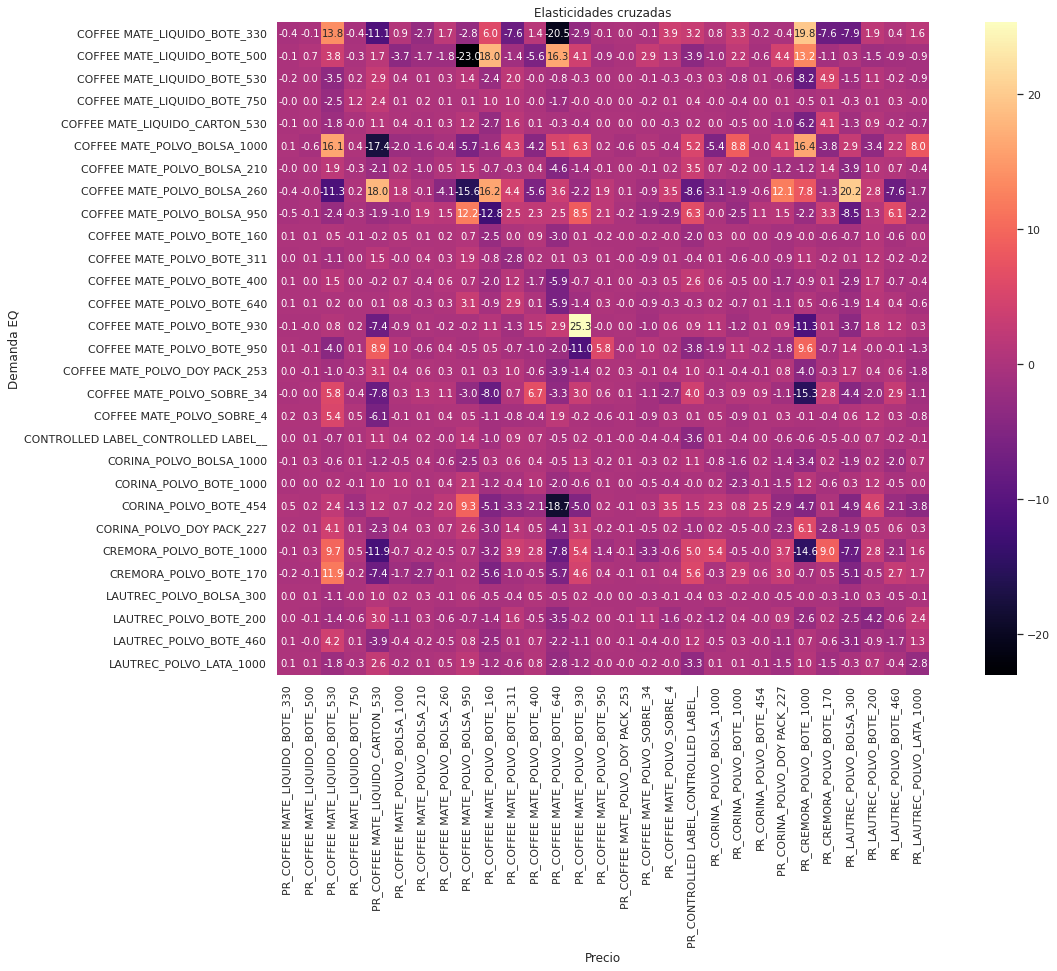

In [34]:
#Graficamos las elasticidades cruzadas en un heatmap
fig, ax = plt.subplots(figsize=(20,12))
hm = sns.heatmap(data = elasticidades_cruzadas, yticklabels = elasticidades_cruzadas.index, xticklabels = elasticidades_cruzadas.columns, 
                 cmap = sns.color_palette('magma', as_cmap=True), annot = True, square = True, fmt = '.1f', ax = ax)
plt.title('Elasticidades cruzadas')
plt.ylabel('Demanda EQ')
plt.xlabel('Precio')
plt.show()
#fig = hm.get_figure()
#fig.savefig('Elasticidades cruzadas.png')

In [35]:
def X_predecir(FE, var_ini = -50, var_fin = 50, var_tam = 1, intercepto = True, delta_sem = 1, sem_prom = 3, FES_mod = []):
  #Las variables 'var' son ´porcentajes y deben ser enteros
  #Generamos el ultimo registro del X de entrenamiento
  sub = acum[(acum['Marca'] == FE) & (acum['ANIO'] == 2021)]
  sub = sub[['date_key','VentasUnidadesEQ']]
  sub = pd.DataFrame(sub.mean(axis = 0)).reset_index(drop = True)
  sub.rename(columns = {0:'VentasUnidadesEQ'}, inplace = True)
  aux = acum[['date_key','Marca','precio']]
  t_actual = len(acum['date_key'].unique())
  #Filtramos por el numero de periodos maximos a promediar
  lista_prom = sorted(acum['date_key'].unique())[-sem_prom:]
  aux = acum[acum['date_key'].isin(lista_prom)]
  #Preparamos el insumo de precios
  precios_pt = pd.pivot_table(aux[['date_key','Marca','precio']], values = 'precio', index = ['date_key'], columns = ['Marca'], aggfunc = np.sum)
  precios_pt.columns = precios_pt.columns.get_level_values(0)
  precios_pt = pd.DataFrame(precios_pt.mean(axis = 0), index = precios_pt.columns).transpose()
  #precios_pt.sort_index(inplace = True)
  precios_pt.columns = ['PR_' + x for x in precios_pt.columns]
  precio_eq_inicial = precios_pt['PR_' + FE][0]
  #sub = sub.merge(precios_pt, how = 'left', on = 'date_key', sort = True)
  sub = pd.concat([sub.reset_index(drop = True), precios_pt], axis = 1)
  X = sub.drop(['VentasUnidadesEQ'], axis = 1).copy()
  #Generamos los factores disponibles
  list_var = list(range(var_ini, var_fin + var_tam, var_tam))
  pct_cambio = [1 + (x / 100) for x in list_var]
  pct_cambio.sort()
  #Armamos el DF en el que van a estar los casos a revisar
  X_acum = pd.DataFrame()
  for i in range(0, len(pct_cambio)):
    X_acum = X_acum.append(X, ignore_index = True)
  #Modificamos los precios de las marcas a modificar el precio
  if FE not in FES_mod:
    FES_mod.append(FE)
  #Modificamos los precios de las marcas a considerar
  for m in FES_mod:
    precio_inicial = X['PR_' + m][0]
    list_precios = [precio_inicial * x for x in pct_cambio]
    X_acum['PR_' + m] = list_precios
  #precio_inicial = X['PR_' + FE][0]
  #list_precios = [precio_inicial * x for x in pct_cambio]
  #X_acum['PR_' + FE] = list_precios
  #Aplicamos logaritmos
  X_acum = X_acum.apply(np.log, axis = 0).copy()
  X_acum['t'] = t_actual + delta_sem - 1
  #Si es necesario agregar el intercepto
  if intercepto == True:
    X_acum = sm.add_constant(X_acum, has_constant = 'add')
  X_acum['VAR'] = list_var
  X_acum.set_index('VAR', inplace = True)
  return X_acum, precio_eq_inicial

In [36]:
X_predecir('COFFEE MATE_POLVO_BOTE_311', var_ini = 10, var_fin = 15, var_tam = 5, intercepto = True, delta_sem = 1, FES_mod = [])

(     const  PR_COFFEE MATE_LIQUIDO_BOTE_330  ...  PR_LAUTREC_POLVO_LATA_1000    t
 VAR                                          ...                                 
 10  1.0000                           2.9957  ...                      4.3082  144
 15  1.0000                           2.9957  ...                      4.3082  144
 
 [2 rows x 31 columns], 147.49349647255508)

In [37]:
print(acum['Marca'].unique())

['COFFEE MATE_LIQUIDO_BOTE_330' 'COFFEE MATE_LIQUIDO_BOTE_500'
 'COFFEE MATE_LIQUIDO_BOTE_530' 'COFFEE MATE_LIQUIDO_BOTE_750'
 'COFFEE MATE_LIQUIDO_CARTON_530' 'COFFEE MATE_POLVO_BOLSA_1000'
 'COFFEE MATE_POLVO_BOLSA_210' 'COFFEE MATE_POLVO_BOLSA_260'
 'COFFEE MATE_POLVO_BOLSA_950' 'COFFEE MATE_POLVO_BOTE_160'
 'COFFEE MATE_POLVO_BOTE_311' 'COFFEE MATE_POLVO_BOTE_400'
 'COFFEE MATE_POLVO_BOTE_640' 'COFFEE MATE_POLVO_BOTE_930'
 'COFFEE MATE_POLVO_BOTE_950' 'COFFEE MATE_POLVO_DOY PACK_253'
 'COFFEE MATE_POLVO_SOBRE_34' 'COFFEE MATE_POLVO_SOBRE_4'
 'CONTROLLED LABEL_CONTROLLED LABEL__' 'CORINA_POLVO_BOLSA_1000'
 'CORINA_POLVO_BOTE_1000' 'CORINA_POLVO_BOTE_454'
 'CORINA_POLVO_DOY PACK_227' 'CREMORA_POLVO_BOTE_1000'
 'CREMORA_POLVO_BOTE_170' 'LAUTREC_POLVO_BOLSA_300'
 'LAUTREC_POLVO_BOTE_200' 'LAUTREC_POLVO_BOTE_460'
 'LAUTREC_POLVO_LATA_1000']


In [38]:
X_test, p_inicial = X_predecir(FE = 'COFFEE MATE_LIQUIDO_BOTE_330', var_ini = -40, var_fin = 40, var_tam = 1, FES_mod = ['COFFEE MATE_LIQUIDO_BOTE_500'])
display(X_test.head())
print(p_inicial)

const  PR_COFFEE MATE_LIQUIDO_BOTE_330  ...  PR_LAUTREC_POLVO_LATA_1000    t
VAR                                          ...                                 
-40 1.0000                           2.4849  ...                      4.3082  144
-39 1.0000                           2.5014  ...                      4.3082  144
-38 1.0000                           2.5177  ...                      4.3082  144
-37 1.0000                           2.5337  ...                      4.3082  144
-36 1.0000                           2.5494  ...                      4.3082  144

[5 rows x 31 columns]

20.0


In [39]:
#Funcion que calcula la sabana de demanda considerando todas las marcas y un DF de variaciones de precio
#Puede devolver {'Unidades EQ', 'Valor', 'Unidad'}
def Sabana_Demanda(X, val = 'Unidades EQ'):
  demanda = pd.DataFrame()
  marcas = acum['Marca'].unique()
  for FE in marcas:
    model_name = FE + '.sav'
    model = pickle.load(open(model_name, 'rb'))
    demanda[FE] = model.predict(X)
  demanda = demanda.apply(np.exp, axis = 0).copy()
  if val == 'Valor':
    precios = X.drop(columns = ['const','t'])
    precios.columns = [x[3:] for x in precios.columns]
    precios = precios.apply(np.exp, axis = 0).copy()
    demanda = demanda.mul(precios)
  elif val == 'Unidad':
    marca_propia = data[data['Marca'] == 'CONTROLLED LABEL_CONTROLLED LABEL__']
    imp_mc = sum(marca_propia['VentasUnidadesEQ']) / sum(marca_propia['VentasUnidades'])
    #Catalogo de factores de conversion
    catalogo_conv = pd.DataFrame(data = {'Marca':acum['Marca'].unique()})
    catalogo_conv['FC'] = [int(re.search('\d+', x)[0]) / 1000 if x != 'CONTROLLED LABEL_CONTROLLED LABEL__' else imp_mc for x in catalogo_conv['Marca']]
    catalogo_conv.set_index('Marca', inplace = True)
    for x in demanda.columns:
      demanda[x] = demanda[x] / catalogo_conv.loc[x, 'FC']
  return demanda

In [40]:
demanda = Sabana_Demanda(X_test, val = 'Unidad')
display(demanda)

COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
-40                        3.3009  ...               1,625.5913
-39                        3.2733  ...               1,630.1843
-38                        3.2464  ...               1,634.7153
-37                        3.2201  ...               1,639.1860
-36                        3.1944  ...               1,643.5983
..                            ...  ...                      ...
 36                        2.1781  ...               1,869.2759
 37                        2.1700  ...               1,871.6149
 38                        2.1620  ...               1,873.9398
 39                        2.1541  ...               1,876.2507
 40                        2.1462  ...               1,878.5479

[81 rows x 29 columns]

In [41]:
#Funcion que grafica la sabana de demanda estimada de una sola marca
#sns.set_theme(style='whitegrid')
def Grafica_Demanda_Marginal(demanda, FE, list_precio, guardar = False):
  fig, ax = plt.subplots(figsize=(15,7))
  axes = [ax, ax.twinx()] #Copiamos el eje
  fig.subplots_adjust(right=0.80) #Hacemos espacio a la derecha
  axes[-1].spines['right'].set_position(('axes', 1)) #Ponemos el ultimo eje copiado a la derecha
  axes[-1].set_frame_on(True)
  axes[-1].patch.set_visible(False)
  dem_sim = sns.lineplot(data = demanda[FE], ax = axes[0], color = 'black')
  axes[1].scatter(x = demanda.index, y = list_precio, alpha = 0.5, c = list_precio)
  plt.title('Demanda simulada ' + FE)
  plt.xlabel('Variacion de precio')
  plt.ylabel('Demanda estimada')
  plt.show()
  if guardar == True:
    fig.savefig('Demanda_Sim_' + FE + '.png')

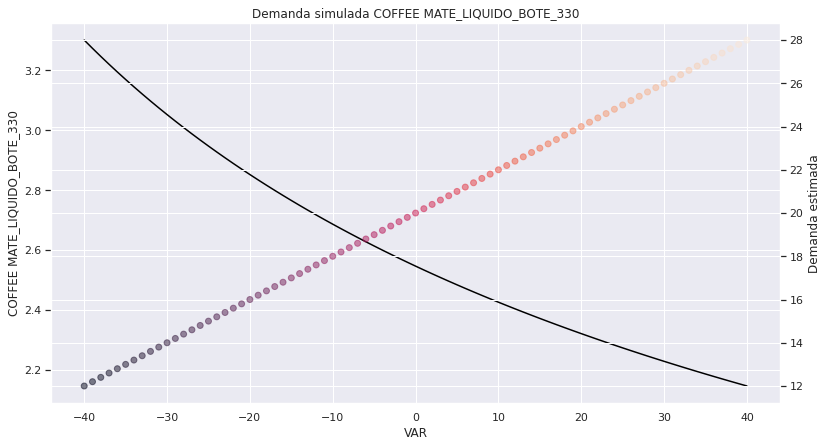

In [42]:
Grafica_Demanda_Marginal(demanda = demanda, FE = 'COFFEE MATE_LIQUIDO_BOTE_330', list_precio = np.exp(X_test['PR_COFFEE MATE_LIQUIDO_BOTE_330']), guardar = False)

###Escenario de precios
Queremos explorar que pasa si incrementamos \\
Polvo +10% y +15% \\
Liquido: +12% y +16%

In [43]:
# Extraemos las marcas a utilizar
marcas_polvo = data[(data['FABRICANTE'] == 'NESTLE') & (data['PRESENTACION'] == 'POLVO') & (data['Marca'].isin(acum['Marca']))]
marcas_polvo = list(marcas_polvo['Marca'].unique())
print(marcas_polvo)

marcas_liquido = data[(data['FABRICANTE'] == 'NESTLE') & (data['PRESENTACION'] == 'LIQUIDO') & (data['Marca'].isin(acum['Marca']))]
marcas_liquido = list(marcas_liquido['Marca'].unique())
print(marcas_liquido)

['COFFEE MATE_POLVO_BOTE_311', 'COFFEE MATE_POLVO_BOTE_640', 'COFFEE MATE_POLVO_BOTE_400', 'COFFEE MATE_POLVO_SOBRE_34', 'COFFEE MATE_POLVO_BOLSA_260', 'COFFEE MATE_POLVO_SOBRE_4', 'COFFEE MATE_POLVO_BOLSA_950', 'COFFEE MATE_POLVO_BOTE_160', 'COFFEE MATE_POLVO_BOLSA_210', 'COFFEE MATE_POLVO_BOTE_930', 'COFFEE MATE_POLVO_DOY PACK_253', 'COFFEE MATE_POLVO_BOTE_950', 'COFFEE MATE_POLVO_BOLSA_1000']
['COFFEE MATE_LIQUIDO_BOTE_750', 'COFFEE MATE_LIQUIDO_BOTE_500', 'COFFEE MATE_LIQUIDO_BOTE_330', 'COFFEE MATE_LIQUIDO_BOTE_530', 'COFFEE MATE_LIQUIDO_CARTON_530']


#Para la presentación polvo

### Demandas marginales

COFFEE MATE_POLVO_BOTE_311


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.4077  ...               1,676.2905
15                         0.2910  ...               1,632.7088

[2 rows x 29 columns]

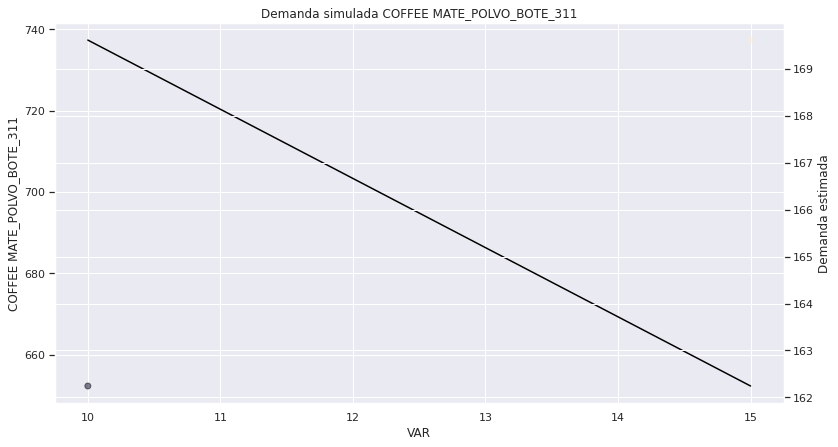

COFFEE MATE_POLVO_BOTE_640


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.1187  ...               1,361.6172
15                         0.0477  ...               1,203.6551

[2 rows x 29 columns]

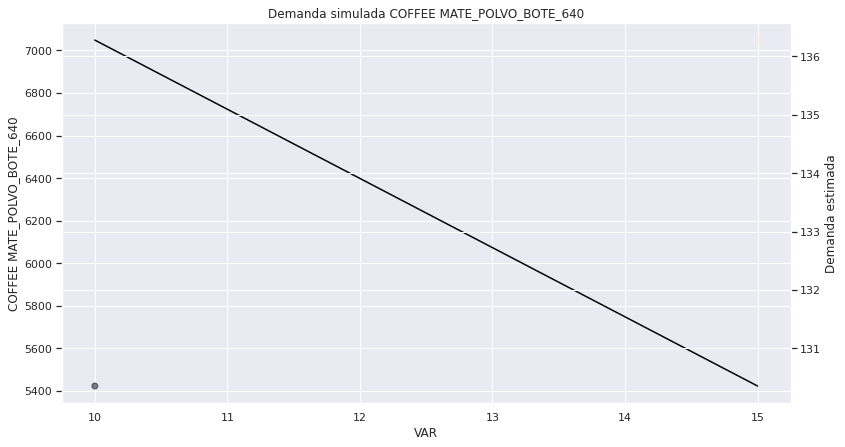

COFFEE MATE_POLVO_BOTE_400


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.9558  ...               1,923.1026
15                         1.0150  ...               1,997.0253

[2 rows x 29 columns]

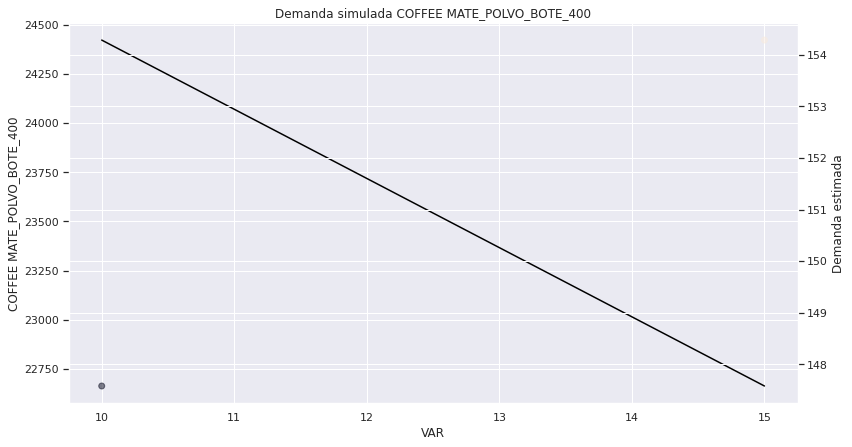

COFFEE MATE_POLVO_SOBRE_34


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.8319  ...               1,740.1800
15                         0.8281  ...               1,724.7655

[2 rows x 29 columns]

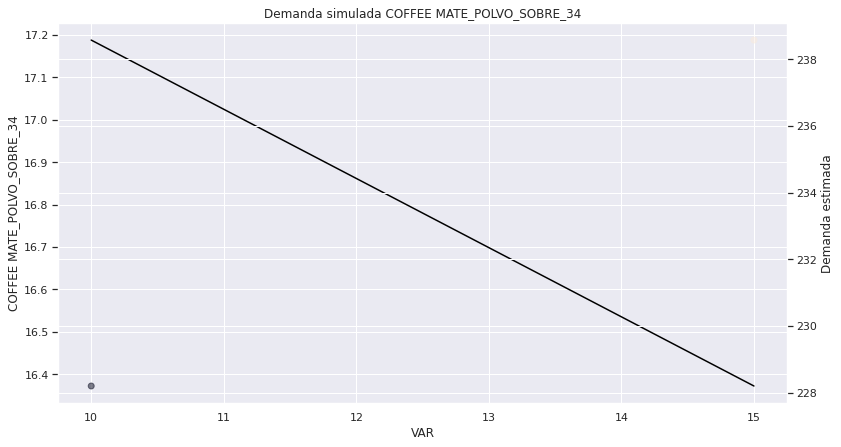

COFFEE MATE_POLVO_BOLSA_260


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.9925  ...               1,859.0354
15                         1.0726  ...               1,900.2289

[2 rows x 29 columns]

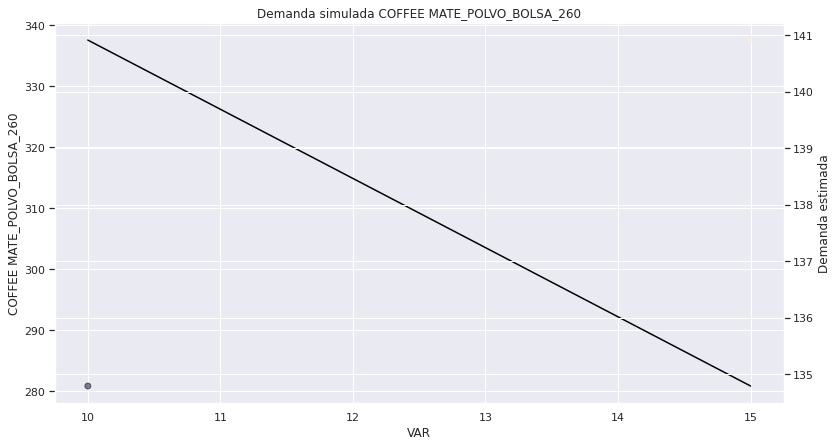

COFFEE MATE_POLVO_SOBRE_4


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         1.2203  ...               1,765.4718
15                         1.4523  ...               1,761.6490

[2 rows x 29 columns]

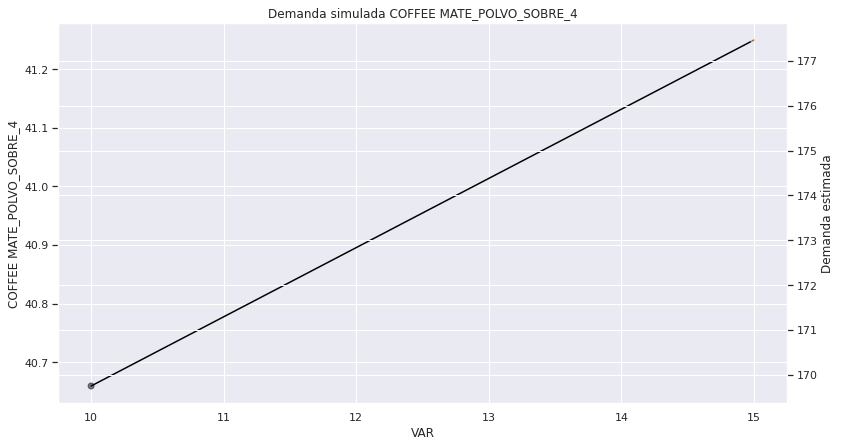

COFFEE MATE_POLVO_BOLSA_950


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.6433  ...               2,135.7217
15                         0.5679  ...               2,328.9824

[2 rows x 29 columns]

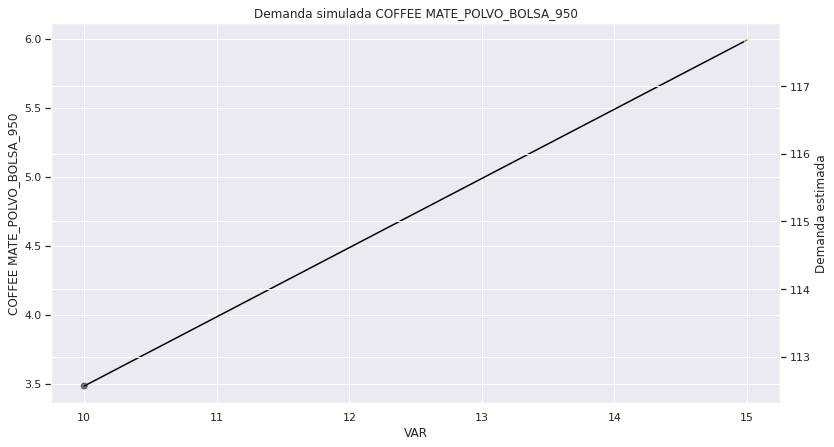

COFFEE MATE_POLVO_BOTE_160


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         1.4922  ...               1,583.7522
15                         1.9505  ...               1,502.2579

[2 rows x 29 columns]

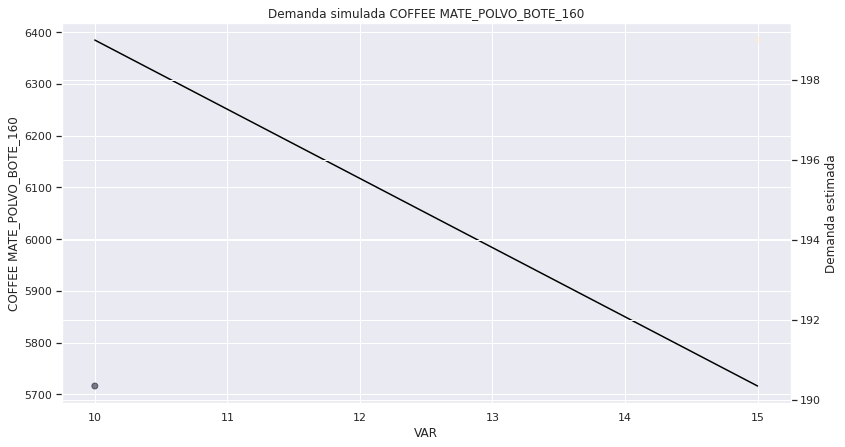

COFFEE MATE_POLVO_BOLSA_210


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.6517  ...               1,789.8586
15                         0.5789  ...               1,797.4467

[2 rows x 29 columns]

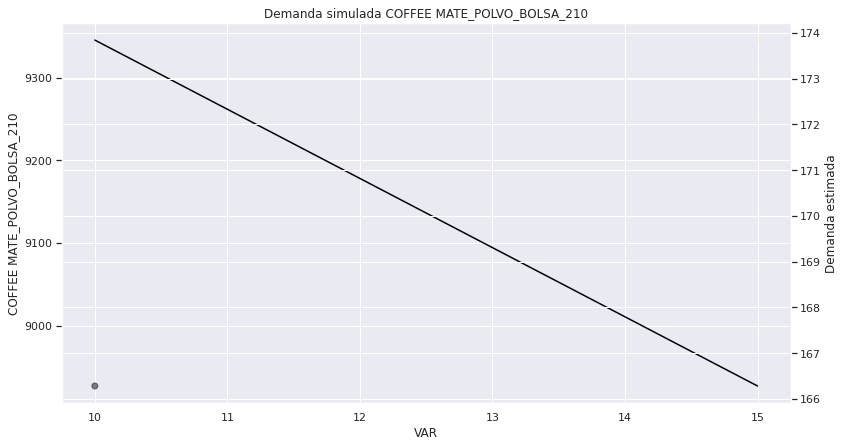

COFFEE MATE_POLVO_BOTE_930


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.6396  ...               1,587.7577
15                         0.5632  ...               1,507.8326

[2 rows x 29 columns]

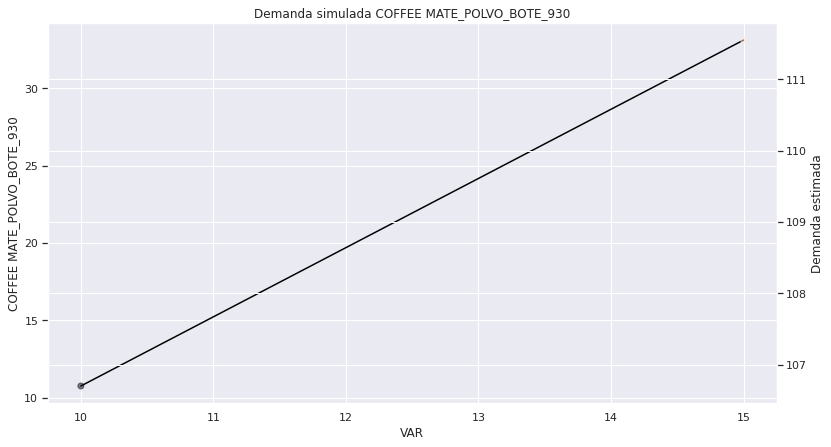

COFFEE MATE_POLVO_DOY PACK_253


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.8417  ...               1,768.9512
15                         0.8423  ...               1,766.7423

[2 rows x 29 columns]

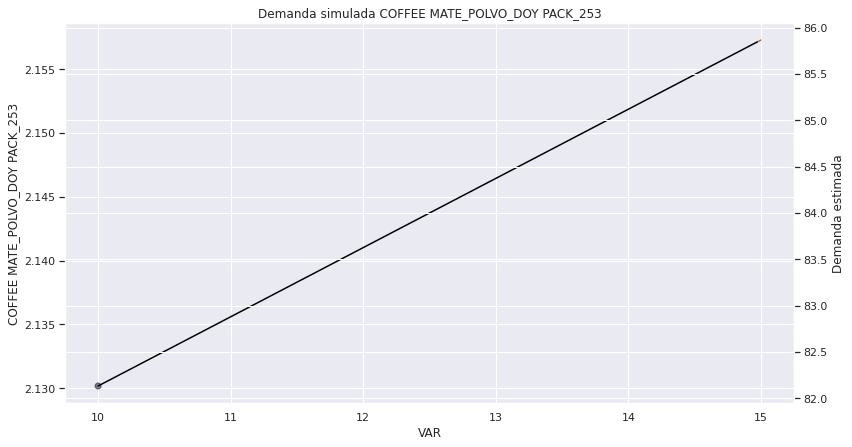

COFFEE MATE_POLVO_BOTE_950


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.8353  ...               1,769.9910
15                         0.8330  ...               1,768.2655

[2 rows x 29 columns]

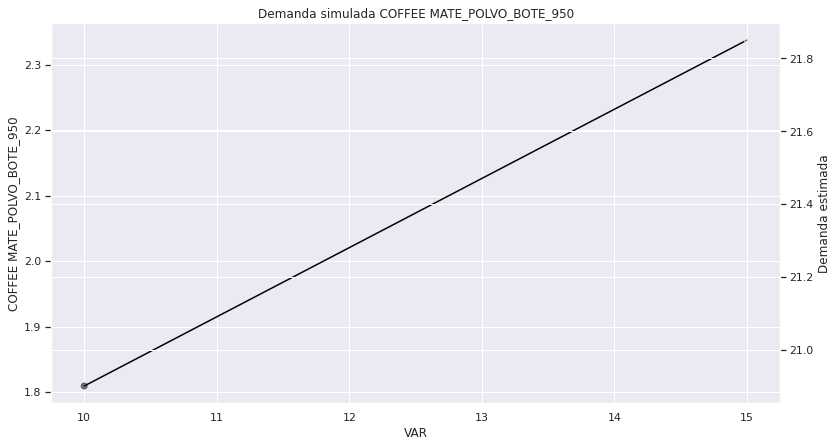

COFFEE MATE_POLVO_BOLSA_1000


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.9172  ...               1,738.1236
15                         0.9554  ...               1,721.7776

[2 rows x 29 columns]

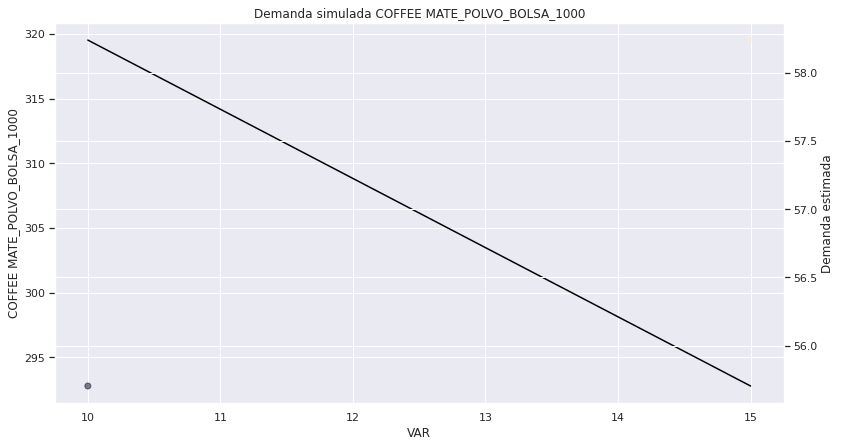

In [44]:
# Demandas con variaciones marginales para polvo
polvo_marginal = {'Marca':[],
                  'Precio_Base':[],
                  'Demanda_Polvo_EQ_10':[],
                  'Demanda_Polvo_EQ_15':[],
                  'Precio_Polvo_EQ_10':[],
                  'Precio_Polvo_EQ_15':[]}
for marca in marcas_polvo:
  print(marca)
  X, pr_inicial = X_predecir(marca, var_ini = 10, var_fin = 15, var_tam = 5, intercepto = True, delta_sem = 1, FES_mod = [])
  demanda = Sabana_Demanda(X)
  display(demanda)
  Grafica_Demanda_Marginal(demanda = demanda, FE = marca, list_precio = np.exp(X['PR_' + marca]), guardar = False)
  #Guardamos los datos a entregar
  polvo_marginal['Marca'].append(marca)
  polvo_marginal['Precio_Base'].append(pr_inicial)
  polvo_marginal['Demanda_Polvo_EQ_10'].append(demanda[marca][10])
  polvo_marginal['Demanda_Polvo_EQ_15'].append(demanda[marca][15])
  polvo_marginal['Precio_Polvo_EQ_10'].append(np.exp(X['PR_' + marca][10]))
  polvo_marginal['Precio_Polvo_EQ_15'].append(np.exp(X['PR_' + marca][15]))
polvo_marginal = pd.DataFrame(polvo_marginal)

### Demandas conjuntas

COFFEE MATE_POLVO_BOTE_311


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

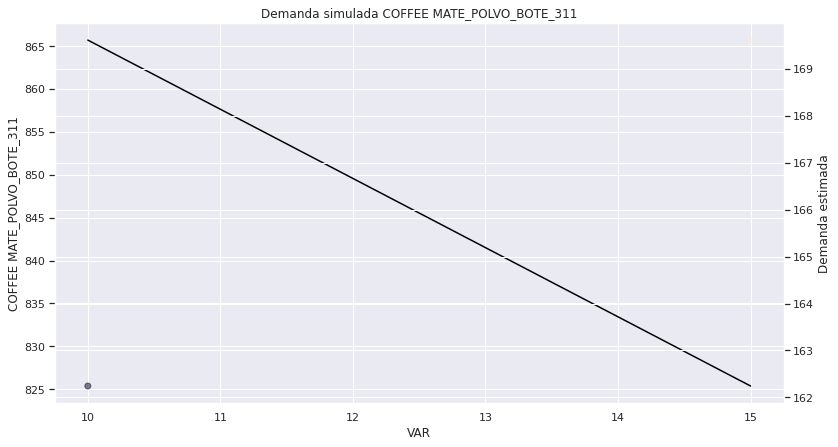

COFFEE MATE_POLVO_BOTE_640


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

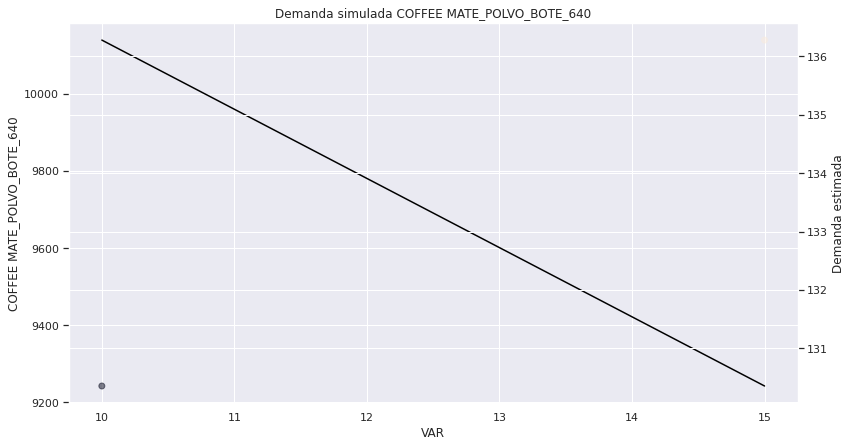

COFFEE MATE_POLVO_BOTE_400


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

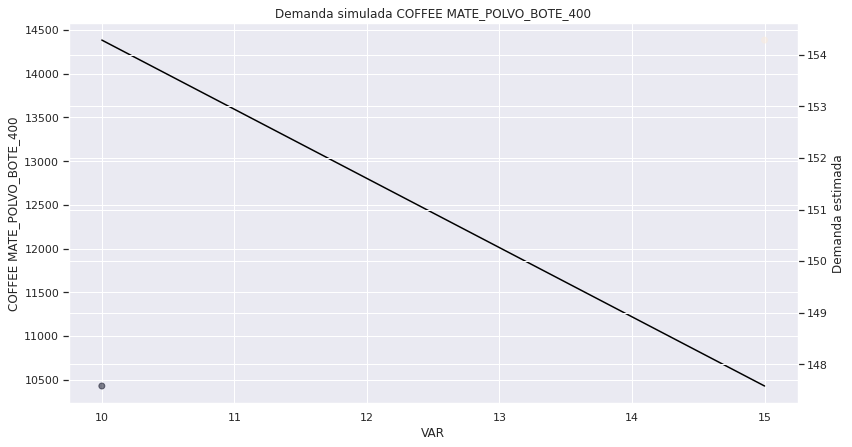

COFFEE MATE_POLVO_SOBRE_34


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

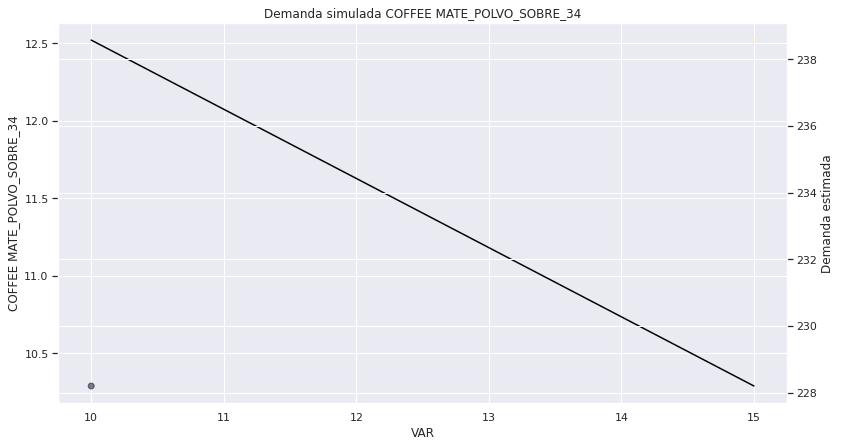

COFFEE MATE_POLVO_BOLSA_260


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

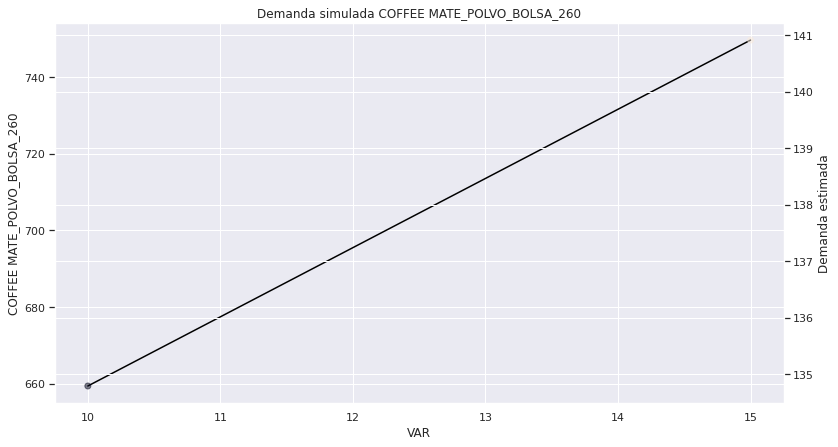

COFFEE MATE_POLVO_SOBRE_4


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

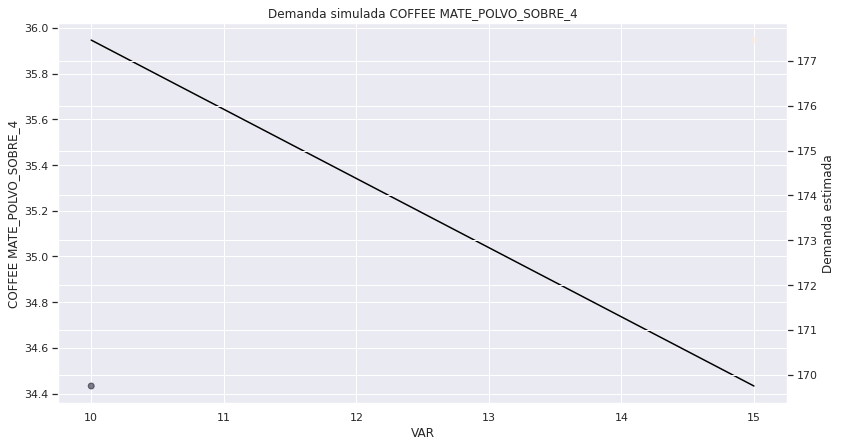

COFFEE MATE_POLVO_BOLSA_950


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

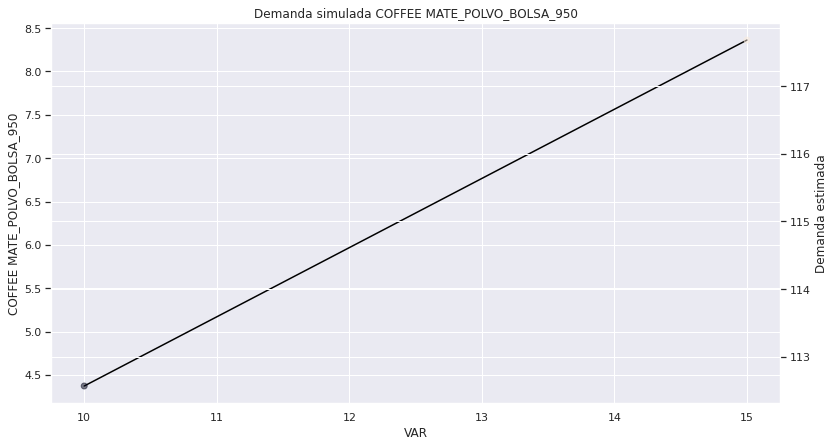

COFFEE MATE_POLVO_BOTE_160


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

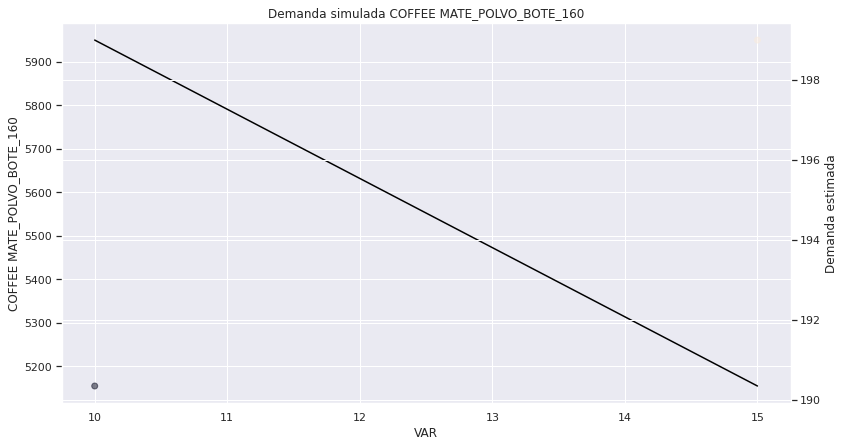

COFFEE MATE_POLVO_BOLSA_210


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

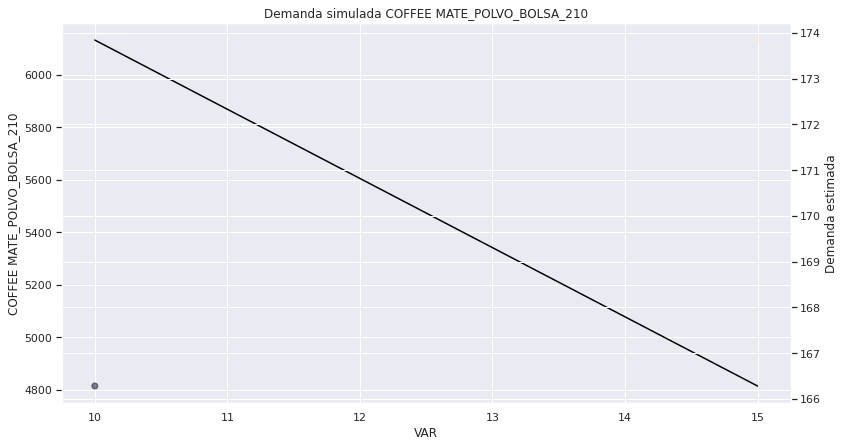

COFFEE MATE_POLVO_BOTE_930


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

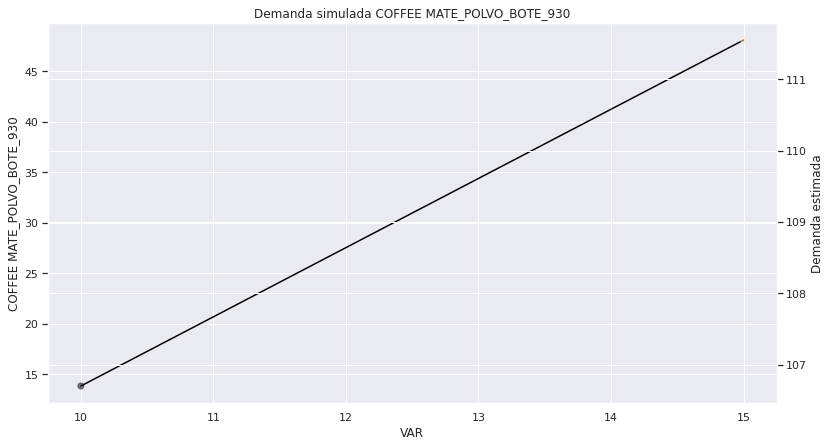

COFFEE MATE_POLVO_DOY PACK_253


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

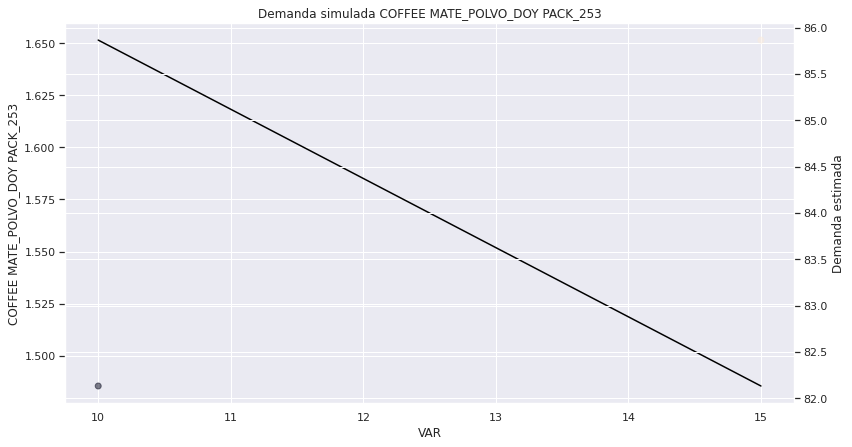

COFFEE MATE_POLVO_BOTE_950


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

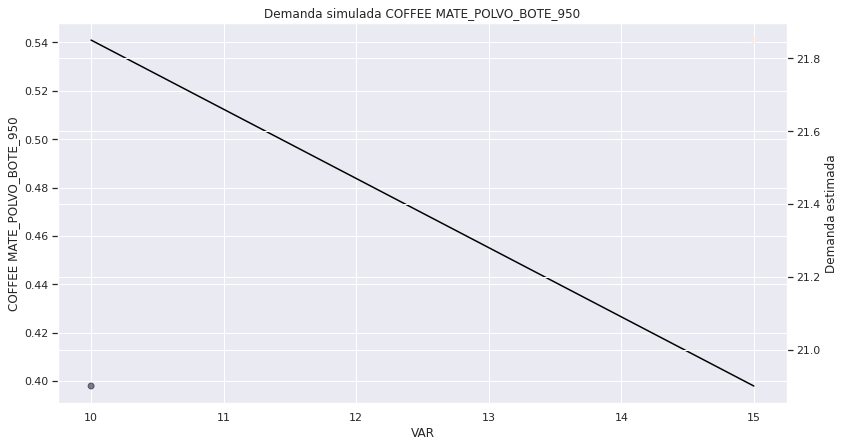

COFFEE MATE_POLVO_BOLSA_1000


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
10                         0.0970  ...               1,352.6956
15                         0.0355  ...               1,192.1081

[2 rows x 29 columns]

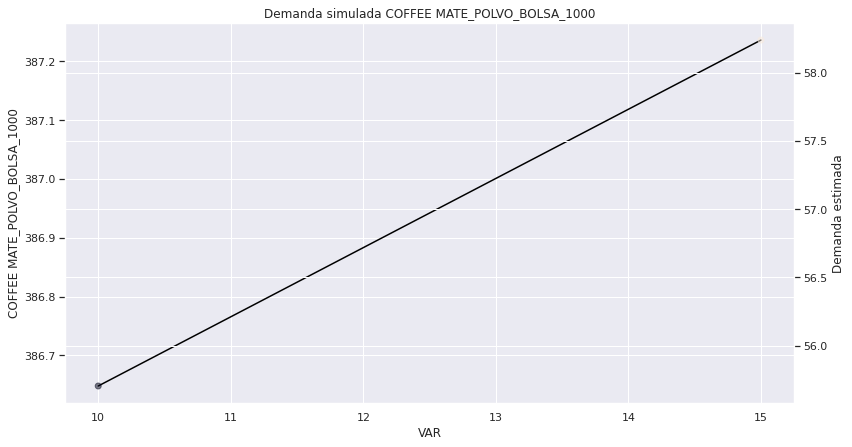

In [45]:
# Demandas con variaciones conjuntas para polvo
polvo_conjunto = {'Marca':[],
                  'Precio_Base':[],
                  'Demanda_Polvo_EQ_10':[],
                  'Demanda_Polvo_EQ_15':[],
                  'Precio_Polvo_EQ_10':[],
                  'Precio_Polvo_EQ_15':[]}
marcas_polvo_it = marcas_polvo.copy()
for marca in marcas_polvo_it:
  print(marca)
  X, pr_inicial = X_predecir(FE = marca, var_ini = 10, var_fin = 15, var_tam = 5, intercepto = True, delta_sem = 1, FES_mod = marcas_polvo.copy())
  demanda = Sabana_Demanda(X)
  display(demanda)
  Grafica_Demanda_Marginal(demanda = demanda, FE = marca, list_precio = np.exp(X['PR_' + marca]), guardar = False)
  #Guardamos los datos a entregar
  polvo_conjunto['Marca'].append(marca)
  polvo_conjunto['Precio_Base'].append(pr_inicial)
  polvo_conjunto['Demanda_Polvo_EQ_10'].append(demanda[marca][10])
  polvo_conjunto['Demanda_Polvo_EQ_15'].append(demanda[marca][15])
  polvo_conjunto['Precio_Polvo_EQ_10'].append(np.exp(X['PR_' + marca][10]))
  polvo_conjunto['Precio_Polvo_EQ_15'].append(np.exp(X['PR_' + marca][15]))
polvo_conjunto = pd.DataFrame(polvo_conjunto)

#Para la presentación liquido

### Demandas marginales

COFFEE MATE_LIQUIDO_BOTE_750


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
12                         0.8004  ...               1,718.9474
16                         0.7885  ...               1,702.3399

[2 rows x 29 columns]

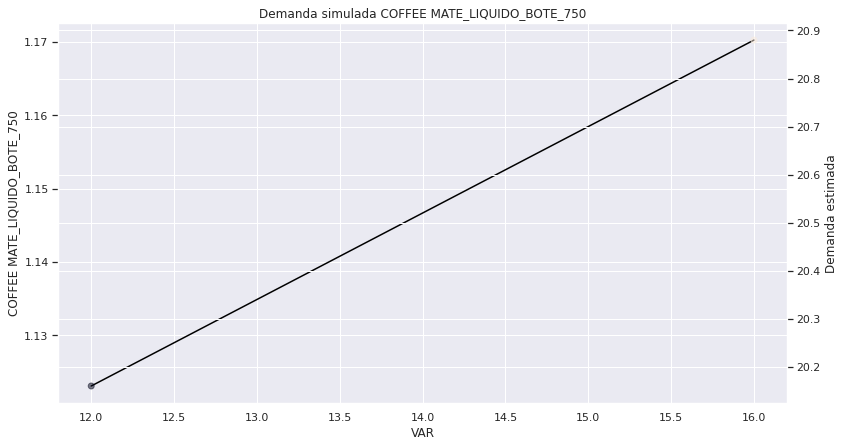

COFFEE MATE_LIQUIDO_BOTE_500


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
12                         0.8294  ...               1,793.8697
16                         0.8261  ...               1,800.1626

[2 rows x 29 columns]

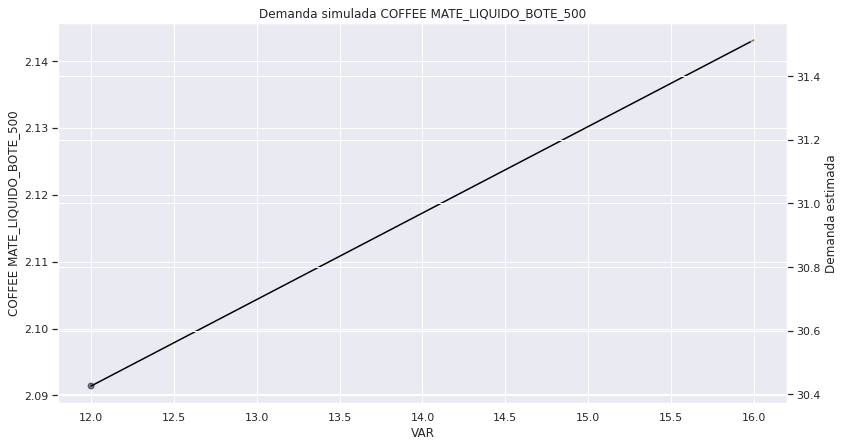

COFFEE MATE_LIQUIDO_BOTE_330


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
12                         0.8037  ...               1,788.0056
16                         0.7927  ...               1,792.4596

[2 rows x 29 columns]

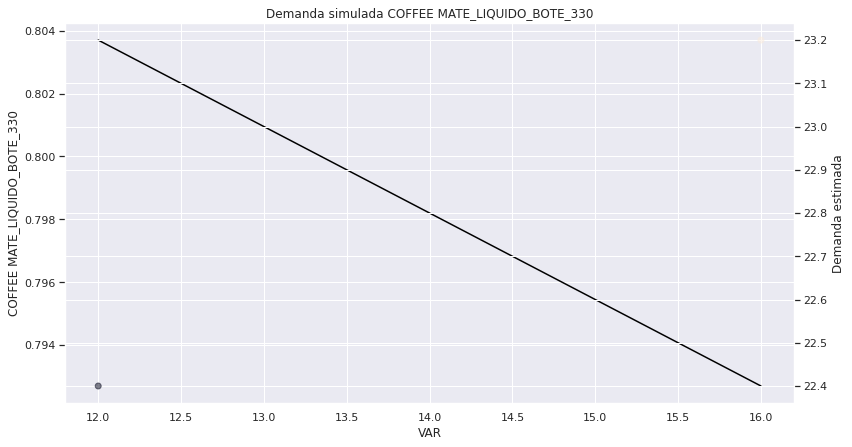

COFFEE MATE_LIQUIDO_BOTE_530


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
12                         4.0335  ...               1,439.0707
16                         6.5558  ...               1,348.8619

[2 rows x 29 columns]

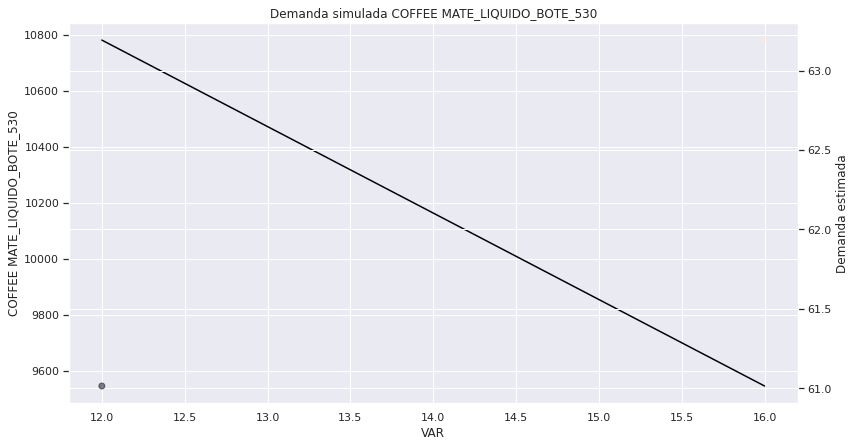

COFFEE MATE_LIQUIDO_CARTON_530


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
12                         0.2398  ...               2,385.6923
16                         0.1626  ...               2,615.0273

[2 rows x 29 columns]

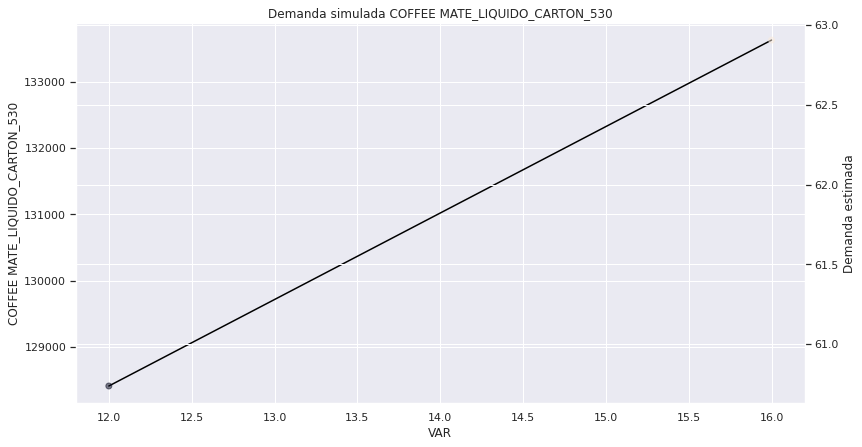

In [46]:
# Demandas con variaciones marginales para liquido
liquido_marginal = {'Marca':[],
                  'Precio_Base':[],
                  'Demanda_Liquido_EQ_12':[],
                  'Demanda_Liquido_EQ_16':[],
                  'Precio_Liquido_EQ_12':[],
                  'Precio_Liquido_EQ_16':[]}
for marca in marcas_liquido:
  print(marca)
  X, pr_inicial = X_predecir(marca, var_ini = 12, var_fin = 16, var_tam = 4, intercepto = True, delta_sem = 1, FES_mod = [])
  demanda = Sabana_Demanda(X)
  display(demanda)
  Grafica_Demanda_Marginal(demanda = demanda, FE = marca, list_precio = np.exp(X['PR_' + marca]), guardar = False)
  #Guardamos los datos a entregar
  liquido_marginal['Marca'].append(marca)
  liquido_marginal['Precio_Base'].append(pr_inicial)
  liquido_marginal['Demanda_Liquido_EQ_12'].append(demanda[marca][12])
  liquido_marginal['Demanda_Liquido_EQ_16'].append(demanda[marca][16])
  liquido_marginal['Precio_Liquido_EQ_12'].append(np.exp(X['PR_' + marca][12]))
  liquido_marginal['Precio_Liquido_EQ_16'].append(np.exp(X['PR_' + marca][16]))
liquido_marginal = pd.DataFrame(liquido_marginal)

### Demandas conjuntas

COFFEE MATE_LIQUIDO_BOTE_750


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
12                         0.0615  ...               1,245.4777
16                         0.0273  ...               1,116.3297

[2 rows x 29 columns]

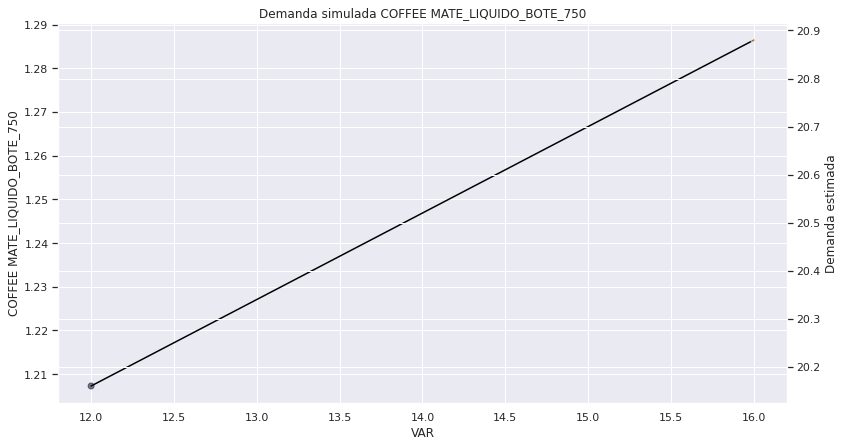

COFFEE MATE_LIQUIDO_BOTE_500


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
12                         0.0637  ...               1,299.7633
16                         0.0287  ...               1,180.4782

[2 rows x 29 columns]

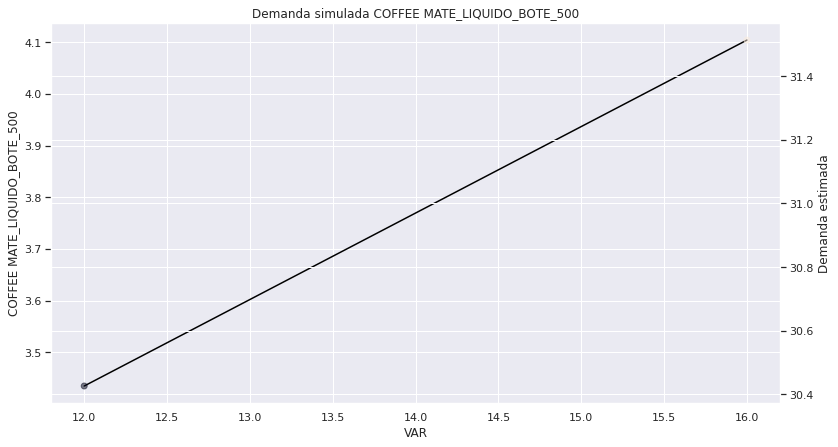

COFFEE MATE_LIQUIDO_BOTE_330


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
12                         0.0617  ...               1,295.5144
16                         0.0275  ...               1,175.4269

[2 rows x 29 columns]

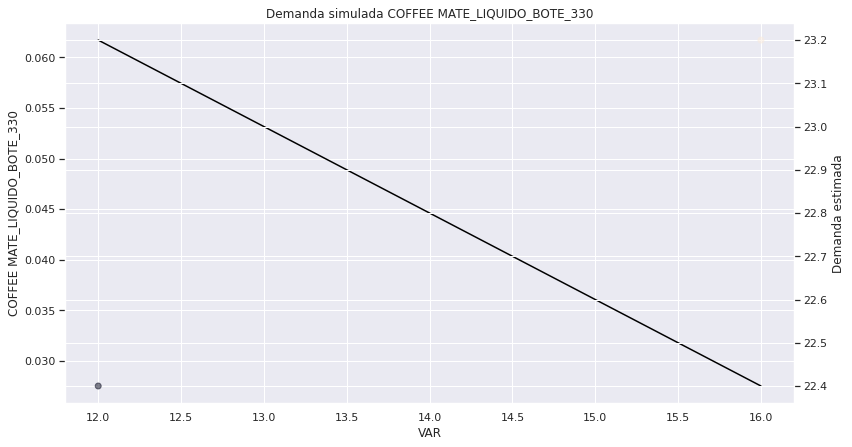

COFFEE MATE_LIQUIDO_BOTE_530


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
12                         0.3097  ...               1,042.6907
16                         0.2274  ...                 884.5324

[2 rows x 29 columns]

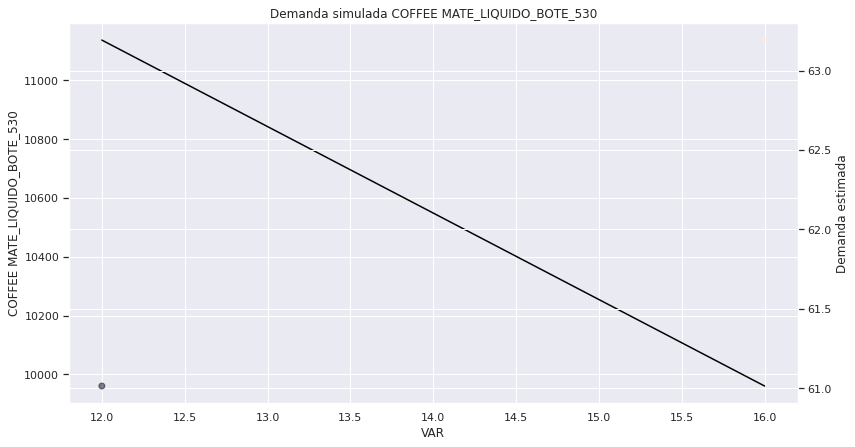

COFFEE MATE_LIQUIDO_CARTON_530


COFFEE MATE_LIQUIDO_BOTE_330  ...  LAUTREC_POLVO_LATA_1000
VAR                                ...                         
12                         0.0184  ...               1,728.5733
16                         0.0056  ...               1,714.8354

[2 rows x 29 columns]

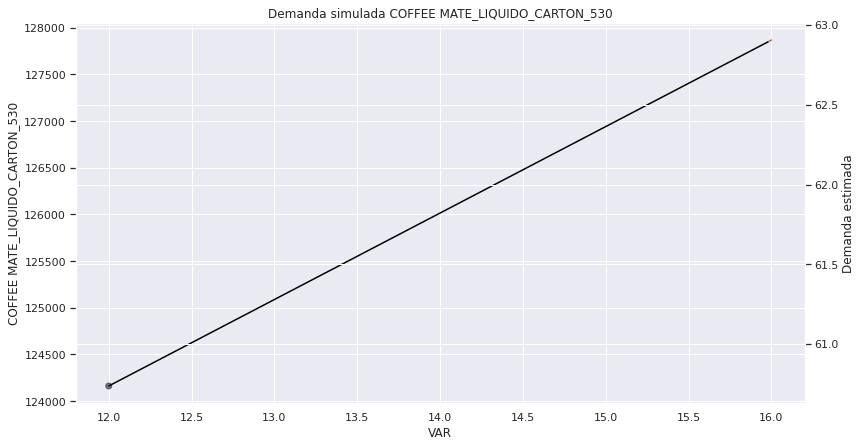

In [47]:
# Demandas con variaciones conjuntas para liquido
liquido_conjunto = {'Marca':[],
                  'Precio_Base':[],
                  'Demanda_Liquido_EQ_12':[],
                  'Demanda_Liquido_EQ_16':[],
                  'Precio_Liquido_EQ_12':[],
                  'Precio_Liquido_EQ_16':[]}
marcas_liquido_it = marcas_liquido.copy()
for marca in marcas_liquido_it:
  print(marca)
  X, pr_inicial = X_predecir(FE = marca, var_ini = 12, var_fin = 16, var_tam = 4, intercepto = True, delta_sem = 1, FES_mod = marcas_polvo.copy())
  demanda = Sabana_Demanda(X)
  display(demanda)
  Grafica_Demanda_Marginal(demanda = demanda, FE = marca, list_precio = np.exp(X['PR_' + marca]), guardar = False)
  #Guardamos los datos a entregar
  liquido_conjunto['Marca'].append(marca)
  liquido_conjunto['Precio_Base'].append(pr_inicial)
  liquido_conjunto['Demanda_Liquido_EQ_12'].append(demanda[marca][12])
  liquido_conjunto['Demanda_Liquido_EQ_16'].append(demanda[marca][16])
  liquido_conjunto['Precio_Liquido_EQ_12'].append(np.exp(X['PR_' + marca][12]))
  liquido_conjunto['Precio_Liquido_EQ_16'].append(np.exp(X['PR_' + marca][16]))
liquido_conjunto = pd.DataFrame(liquido_conjunto)

In [48]:
#Preparamos la base del output
base = data[data['ANIO'] == 2021].copy()
base = base.groupby(['Marca', 'PRESENTACION'])['VentasValor', 'VentasUnidades', 'VentasUnidadesEQ'].agg([np.mean]).reset_index()
base.columns = base.columns.get_level_values(0)

#Creamos el dataframe de las marginales
base_marginal = base.merge(polvo_marginal, how = 'outer', on = 'Marca')
base_marginal = base_marginal.merge(liquido_marginal, how = 'outer', on = 'Marca')
base_marginal['Precio_Base_x'] = base_marginal['Precio_Base_x'].combine_first(base_marginal['Precio_Base_y'])
#Consideramos solo las marcas que se modelaron
base_marginal = base_marginal[~base_marginal['Precio_Base_x'].isna()]
base_marginal.drop(['Precio_Base_y'], axis = 1, inplace = True)
base_marginal.rename(columns = {'Precio_Base_x':'Precio_Base'}, inplace = True)
base_marginal.to_csv('Base_Marginal.csv', index=False)

#Creamos el dataframe de las conjuntas
base_conjunta = base.merge(polvo_conjunto, how = 'outer', on = 'Marca')
base_conjunta = base_conjunta.merge(liquido_conjunto, how = 'outer', on = 'Marca')
base_conjunta['Precio_Base_x'] = base_conjunta['Precio_Base_x'].combine_first(base_conjunta['Precio_Base_y'])
#Consideramos solo las marcas que se modelaron
base_conjunta = base_conjunta[~base_conjunta['Precio_Base_x'].isna()]
base_conjunta.drop(['Precio_Base_y'], axis = 1, inplace = True)
base_conjunta.rename(columns = {'Precio_Base_x':'Precio_Base'}, inplace = True)
base_conjunta.to_csv('Base_Conjunta.csv', index=False)

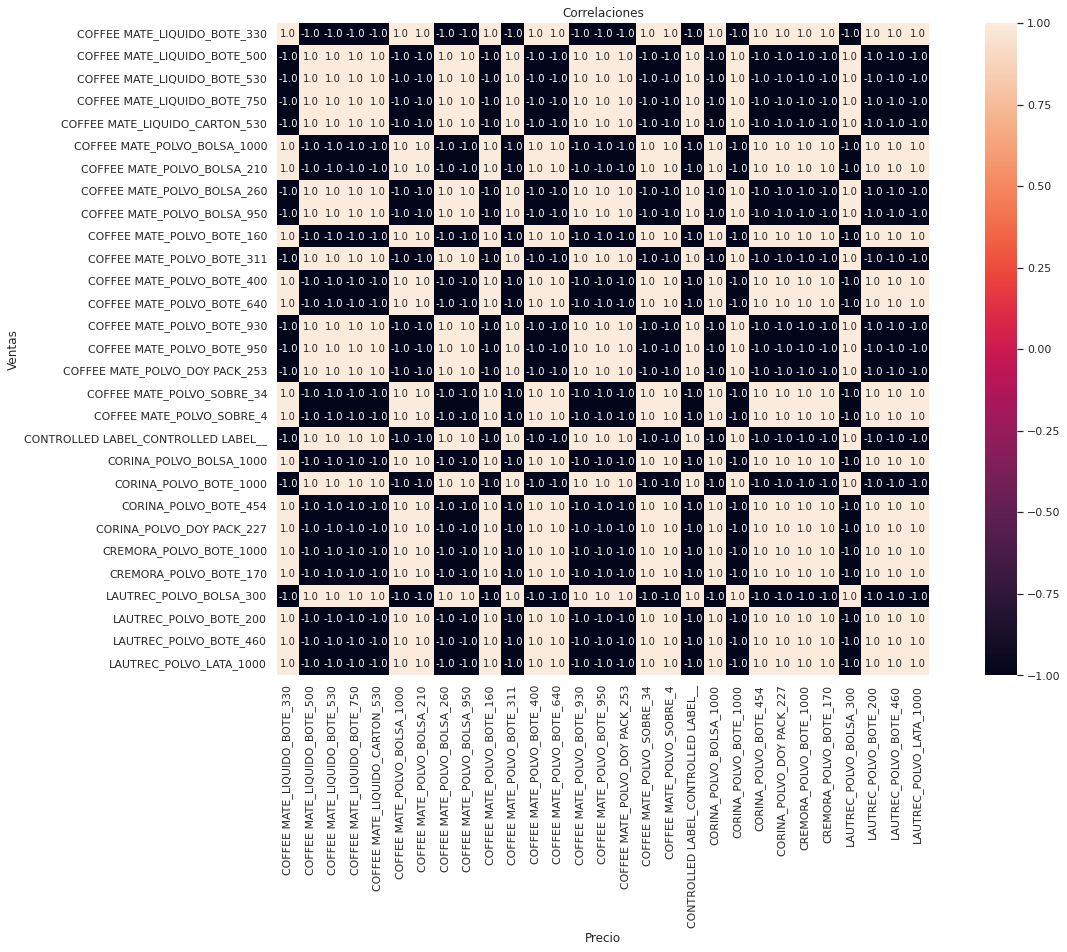

In [49]:
#Grafica de las correlaciones
correlaciones = demanda.corr()
fig, ax = plt.subplots(figsize = (20,12))
sns.heatmap(data = correlaciones, yticklabels = correlaciones.index, 
            xticklabels = correlaciones.columns, annot = True, square = True, fmt = '.1f', ax = ax)
plt.title('Correlaciones')
plt.xlabel("Precio")
plt.ylabel("Ventas")
plt.show()

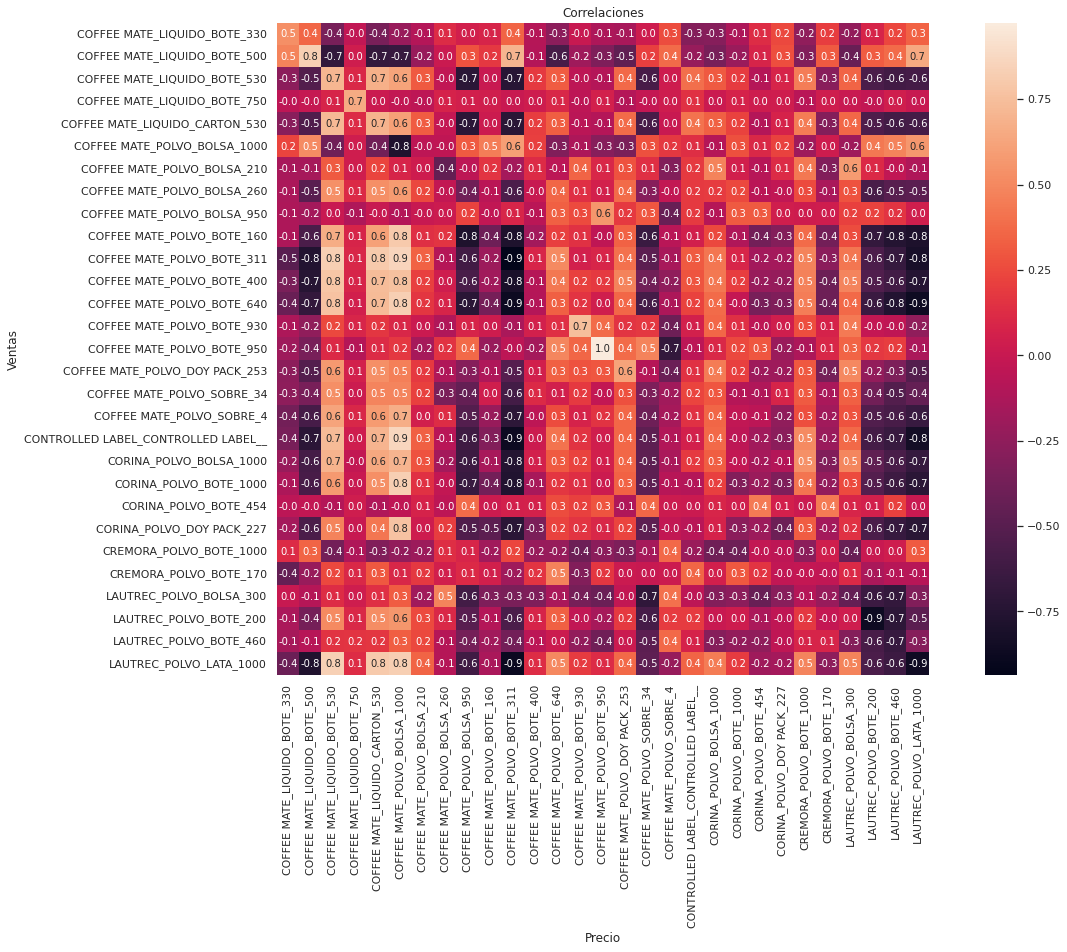

In [50]:
#Correlaciones
correlaciones = pd.pivot_table(acum, values = ['VentasUnidadesEQ','precio'], index = 'date_key', columns = 'Marca')
correlaciones = correlaciones.corr(method = 'spearman')

correlaciones.drop('VentasUnidadesEQ', level = 0, inplace = True)
correlaciones.drop('precio', level = 0, axis = 1, inplace = True)

fig, ax = plt.subplots(figsize = (20,12))
sns.heatmap(data = correlaciones, yticklabels = correlaciones.columns.get_level_values(1), 
            xticklabels = correlaciones.index.get_level_values(1), annot = True, square = True, fmt = '.1f', ax = ax)
plt.title('Correlaciones')
plt.xlabel("Precio")
plt.ylabel("Ventas")
plt.show()

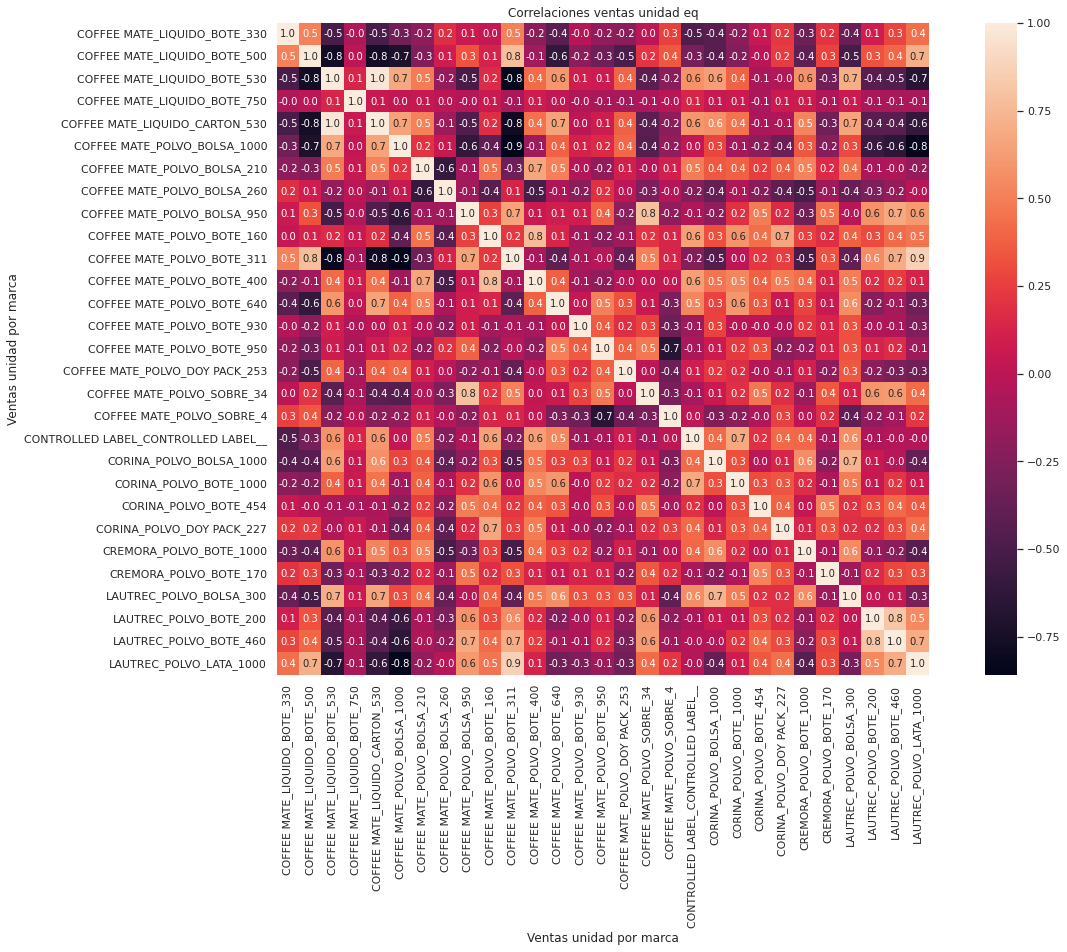

In [51]:
#Correlaciones ventas por kilo
correlaciones = pd.pivot_table(acum, values = ['VentasUnidadesEQ'], index = 'date_key', columns = 'Marca')
correlaciones = correlaciones.corr(method = 'spearman')

fig, ax = plt.subplots(figsize = (20,12))
sns.heatmap(data = correlaciones, yticklabels = correlaciones.columns.get_level_values(1), 
            xticklabels = correlaciones.index.get_level_values(1), annot = True, square = True, fmt = '.1f', ax = ax)
plt.title('Correlaciones ventas unidad eq')
plt.xlabel("Ventas unidad por marca")
plt.ylabel("Ventas unidad por marca")
plt.show()

In [53]:
# VIF Si hay mucha multicolinealidad en todo :(
dic_vif = {}
for FE in resultados['FEs']:
    #Preparamos los datos a usar
    sub = acum[acum['Marca'] == FE]
    sub = sub[['date_key','VentasUnidadesEQ']]
    precios_pt = pd.pivot_table(acum[['date_key','Marca','precio']], values='precio', index=['date_key'],columns=['Marca'], aggfunc=np.sum)
    precios_pt.columns = precios_pt.columns.get_level_values(0)
    precios_pt.columns = ['PR_' + x for x in precios_pt.columns]
    sub = sub.merge(precios_pt, how = 'left', on = 'date_key', sort = True)
    aux = sub.drop(['date_key'], axis = 1).apply(np.log, axis = 0).copy()#dropna()
    aux['t'] = range(0, aux.shape[0])
    y = aux['VentasUnidadesEQ'].copy()
    X = aux.drop(['VentasUnidadesEQ'], axis = 1).copy()
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
    dic_vif[FE] = vif_data
display(dic_vif)

{'COFFEE MATE_LIQUIDO_BOTE_330':                                    feature          VIF
 0          PR_COFFEE MATE_LIQUIDO_BOTE_330     283.2579
 1          PR_COFFEE MATE_LIQUIDO_BOTE_500     183.1860
 2          PR_COFFEE MATE_LIQUIDO_BOTE_530 351,817.9195
 3          PR_COFFEE MATE_LIQUIDO_BOTE_750   1,629.4742
 4        PR_COFFEE MATE_LIQUIDO_CARTON_530 378,529.2118
 5          PR_COFFEE MATE_POLVO_BOLSA_1000   4,965.2170
 6           PR_COFFEE MATE_POLVO_BOLSA_210   5,525.8590
 7           PR_COFFEE MATE_POLVO_BOLSA_260   6,021.5405
 8           PR_COFFEE MATE_POLVO_BOLSA_950  51,195.1760
 9            PR_COFFEE MATE_POLVO_BOTE_160  65,161.7346
 10           PR_COFFEE MATE_POLVO_BOTE_311  85,894.1995
 11           PR_COFFEE MATE_POLVO_BOTE_400  19,165.8744
 12           PR_COFFEE MATE_POLVO_BOTE_640 173,077.0146
 13           PR_COFFEE MATE_POLVO_BOTE_930  77,865.3752
 14           PR_COFFEE MATE_POLVO_BOTE_950      92.5942
 15       PR_COFFEE MATE_POLVO_DOY PACK_253      59.2450

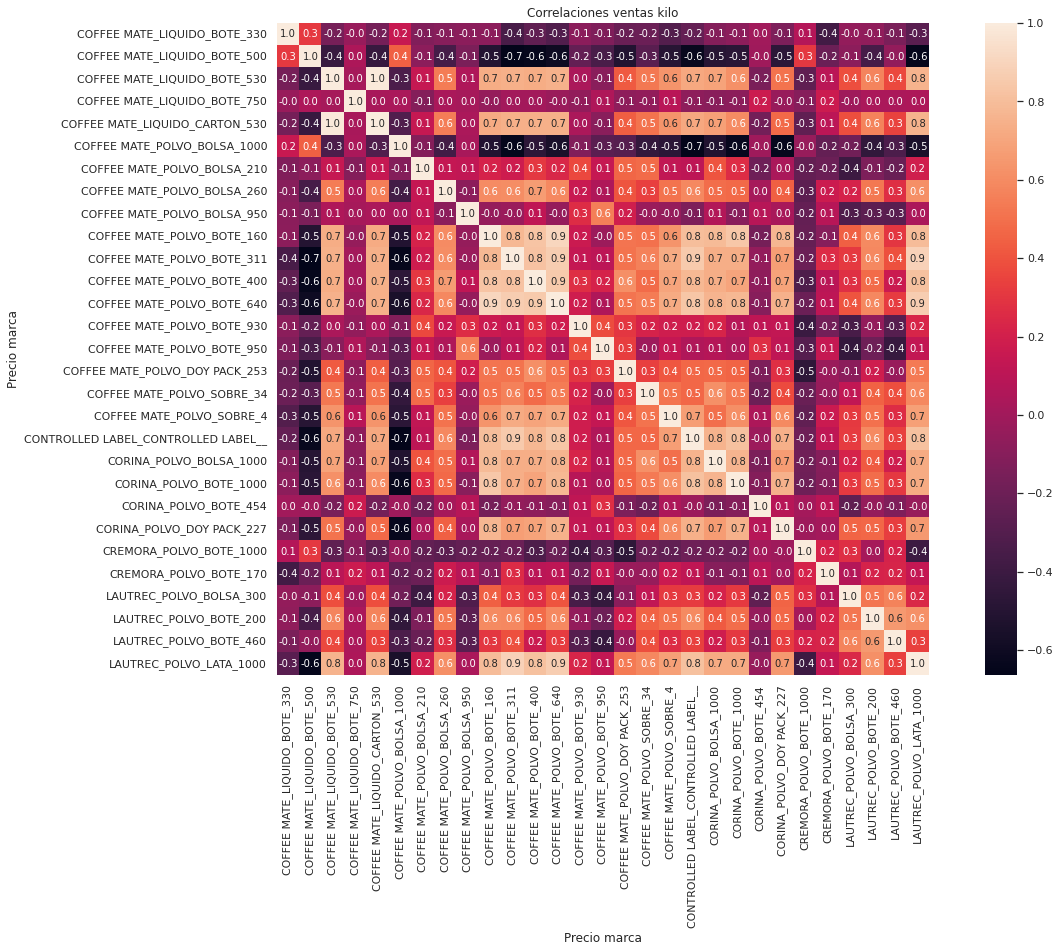

In [54]:
#Correlaciones ventas por precio
correlaciones = pd.pivot_table(acum, values = ['precio'], index = 'date_key', columns = 'Marca')
correlaciones = correlaciones.corr(method='spearman')

fig, ax = plt.subplots(figsize=(20,12))
sns.heatmap(data = correlaciones, yticklabels = correlaciones.columns.get_level_values(1), 
            xticklabels = correlaciones.index.get_level_values(1), annot = True, square = True, fmt = '.1f', ax = ax)
plt.title('Correlaciones ventas kilo')
plt.xlabel("Precio marca")
plt.ylabel("Precio marca")
plt.show()

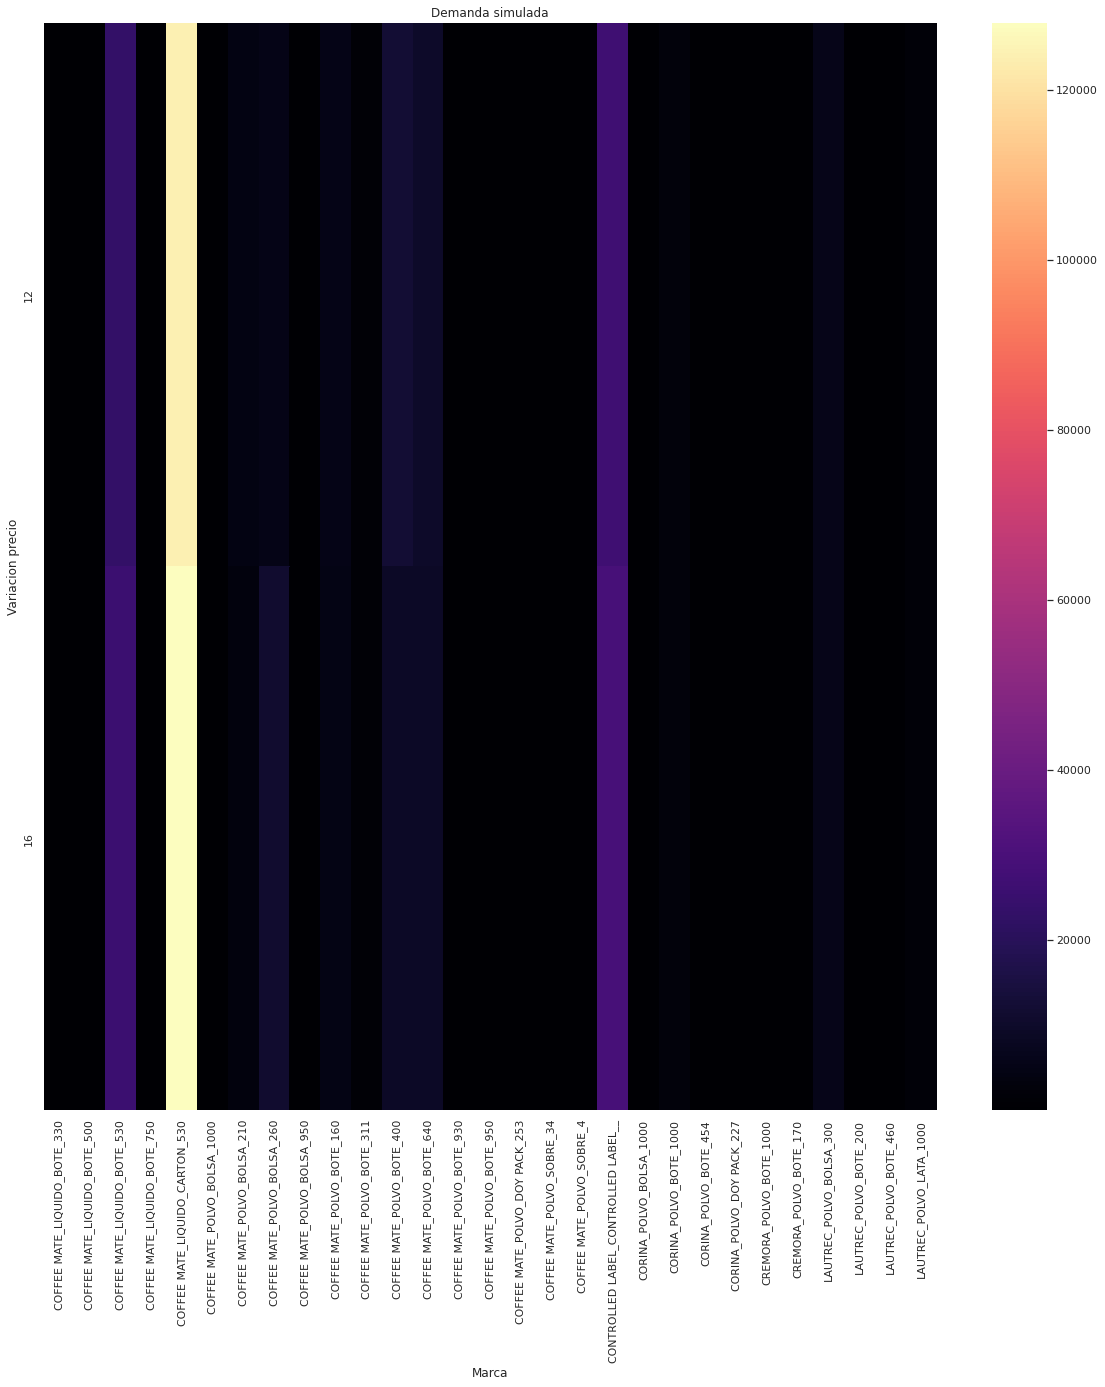

In [55]:
#Graficamos las demandas de las marcas en un heatmap
fig, ax = plt.subplots(figsize=(20,20))
hm = sns.heatmap(data = demanda, yticklabels = demanda.index, xticklabels = demanda.columns,
                 cmap = sns.color_palette('magma', as_cmap=True), ax = ax)
plt.title('Demanda simulada')
plt.xlabel('Marca')
plt.ylabel('Variacion precio')
plt.show()
#fig = hm.get_figure()
#fig.savefig('Elasticidades cruzadas.png')